<a href="https://colab.research.google.com/github/jay-nakrani/Gold-Performance-Forecasting-A-Machine-Learning-Approach-with-Economic-Data/blob/main/gold_price_forecasting_wdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gold Performance Forecasting: A Machine Learning Approach with Economic Data

# Step-1 : *Data collection, analysis and cleaning.*

In [6]:
# To install required packages and import libraries.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:
# Function to get the data.
def get_data(start='2000-01-01'):
    """
    To download all the required data from Yahoo finance using yfinance-
    library.(From 2000 to Today)

    parameters: start= start date of data.

    returns: dictionary of all the downloaded data.
    """

    # To download all the required data from Yahoo finance using yfinance-
    # library.(From 2000 to Today)
    # Gold futures.
    gold = yf.download('GC=F', start=start, progress=False)
    # Treasury yield.(thirty years treasury yield)
    treasury_yield = yf.download('^TYX', start=start, progress=False)
    # USD Index.
    usd_index = yf.download('DX=F', start=start, progress=False)
    # Volatility Index (VIX).
    vix = yf.download('^VIX', start=start, progress=False)
    # US oil futures.
    oil = yf.download('CL=F', start=start, auto_adjust=True)
    # Silver futures.
    silver = yf.download('SI=F', start=start, progress=False)

    # To download inflation data (CPI) from federal reserve economic data (FRED).
    cpi_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=CPIAUCSL"
    cpi_data = pd.read_csv(cpi_url, index_col=0, parse_dates=True)
    cpi_data.columns = ['CPI']

    # To keep CPI data from year 1999 onwards.
    # # All other data starts from year 2000 but here we need one more year to
    # # calculate anual inflation for year 2000.

    # Convert start to datetime.
    start_date = pd.to_datetime(start)

    # Calculate CPI start date (1 year before start date).
    cpi_start_date = start_date - pd.DateOffset(years=1)
    cpi_start_str = cpi_start_date.strftime('%Y-%m-%d')

    cpi_data = cpi_data[cpi_data.index >= cpi_start_str]

    # To calculate annual inflation rate.
    # For example: march,2024-march,2025; april,2024- april,2025 etc..
    cpi_data['Inflation_Annual'] = cpi_data['CPI'].pct_change(12) * 100  # Year-over-year

    # To keep CPI data from 2000-01-01 onwards for analysis as all other data is from
    # year 2000.
    cpi_data_final = cpi_data[cpi_data.index >= start]

    # Resample to daily frequency with forward fill.
    inflation_annual_daily = cpi_data_final['Inflation_Annual'].resample('D').ffill()

    return {
        'gold': gold,
        'treasury_yield': treasury_yield,
        'usd_index': usd_index,
        'vix': vix,
        'oil': oil,
        'silver': silver,
        'inflation_annual': inflation_annual_daily
    }

dataframe = get_data(start='2000-01-01')

/tmp/ipython-input-7229435.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download('GC=F', start=start, progress=False)
/tmp/ipython-input-7229435.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury_yield = yf.download('^TYX', start=start, progress=False)
/tmp/ipython-input-7229435.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_index = yf.download('DX=F', start=start, progress=False)
/tmp/ipython-input-7229435.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start, progress=False)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-7229435.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver = yf.download('SI=F', start=start, progress=False)
/tmp/ipython-input-7229435.py:47: FutureWarning: The default fill

In [8]:
# To check each downloaded data.
datasets_to_check = {
    'Gold': dataframe['gold'],
    'Treasury_yield': dataframe['treasury_yield'],
    'USD Index': dataframe['usd_index'],
    'VIX': dataframe['vix'],
    'US Oil': dataframe['oil'],
    'Silver': dataframe['silver'],
    'Inflation Annual Daily': dataframe['inflation_annual']
}

for name, data in datasets_to_check.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Shape: {data.shape}")
    print(f"Date Range: {data.index[0]} to {data.index[-1]}")
    print("\nFirst 3 rows:\n")
    print(data.tail(3))
    print("\nData types:\n")
    print(data.dtypes)
    print(f"Missing values: {data.isnull().sum().sum()}")

    print("-" * 50)
    print("-" * 50)

# To check if all the data is in same range or not.
print("\nDATE RANGE COMPARISON")
print("=" * 50)

for name, data in datasets_to_check.items():

    # String representation used to avoid errors.
    start_date = str(data.index[0])[:10]  # Get first 10 characters (YYYY-MM-DD)
    end_date = str(data.index[-1])[:10]

    print(f"{name:25} | {start_date} to {end_date} | {len(data):6} records")



=== GOLD ===
Shape: (6352, 5)
Date Range: 2000-08-30 00:00:00 to 2025-12-22 00:00:00

First 3 rows:

Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2025-12-18  4339.500000  4348.100098  4328.200195  4331.000000    705
2025-12-19  4361.399902  4361.399902  4350.100098  4350.100098   1065
2025-12-22  4518.899902  4530.799805  4479.799805  4481.799805  44586

Data types:

Price   Ticker
Close   GC=F      float64
High    GC=F      float64
Low     GC=F      float64
Open    GC=F      float64
Volume  GC=F        int64
dtype: object
Missing values: 0
--------------------------------------------------
--------------------------------------------------

=== TREASURY_YIELD ===
Shape: (6527, 5)
Date Range: 2000-01-03 00:00:00 to 2025-12-22 00:00:00

First 3 rows:

Price       Close   High    Low   Open Volume
Ticker       ^TYX   ^TYX   

In [9]:
# function to combine all the data we collected with it's daily close.

def combine_market_data(data):

    """
    This function helps to create a combined dataset of all collected data with-
    it's daily close.

    Parameters: data (dict): A dictionary containing different market datasets.

    Returns: combined_data (pandas.DataFrame): A combined dataset with all-
             features aligned to daily frequency.

    """
    # Now we can combine all the datasets into one dataset. we require only close
    # price from each day for further analysis.

    # create a copy to avoid modifying original dataframe.
    data = data.copy()

    # To initialize combined dataframe.
    combined_data = pd.DataFrame()

    # To extract close prices from each dataset.
    combined_data['Gold_Price'] = data['gold'][('Close', 'GC=F')]
    combined_data['Treasury_yield'] = data['treasury_yield'][('Close', '^TYX')]
    combined_data['USD_Index'] = data['usd_index'][('Close', 'DX=F')]
    combined_data['VIX'] = data['vix'][('Close', '^VIX')]
    combined_data['OIL'] = data['oil'][('Close', 'CL=F')]
    combined_data['SILVER'] = data['silver'][('Close', 'SI=F')]

    # Inflation annual has different end date than other data.
    # Inflation data we get every month but it is for the last month. For example
    # current month is october so we get the inflation data of september in the
    # starting of october. This data don't change daily so we can forward fill it
    # with the last known value.
    # So here we will forward fill it till last date of gold dataset.
    target_end = data['gold'].index[-1]

    inflation_annual_extended = data['inflation_annual'].reindex(
        pd.date_range(start=data['inflation_annual'].index[0], end=target_end, freq='D')
        ).ffill()

    # Inflation annual has only one value in dataset so we do not need to
    # extract close price from it.
    combined_data['Inflation_Annual'] = inflation_annual_extended

    # Remove any missing values from the combined dataset.
    combined_data = combined_data.dropna()

    return combined_data

combined_df = combine_market_data(dataframe)

In [10]:
print(f"Shape: {combined_df.shape}")
print(f"Date range: {combined_df.index[0]} to {combined_df.index[-1]}")
print("\nCombined data information")
print("=" * 40 + "\n")
print(combined_df.info())
print("\nMissing values:")
print(combined_df.isnull().sum())
print("\nBasic statistics:")
print(combined_df.describe())

Shape: (6338, 7)
Date range: 2000-08-30 00:00:00 to 2025-12-22 00:00:00

Combined data information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6338 entries, 2000-08-30 to 2025-12-22
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gold_Price        6338 non-null   float64
 1   Treasury_yield    6338 non-null   float64
 2   USD_Index         6338 non-null   float64
 3   VIX               6338 non-null   float64
 4   OIL               6338 non-null   float64
 5   SILVER            6338 non-null   float64
 6   Inflation_Annual  6338 non-null   float64
dtypes: float64(7)
memory usage: 396.1 KB
None

Missing values:
Gold_Price          0
Treasury_yield      0
USD_Index           0
VIX                 0
OIL                 0
SILVER              0
Inflation_Annual    0
dtype: int64

Basic statistics:
        Gold_Price  Treasury_yield    USD_Index          VIX          OIL  \
count  6338.000000     633

# Step-2 : *Data visualization.*

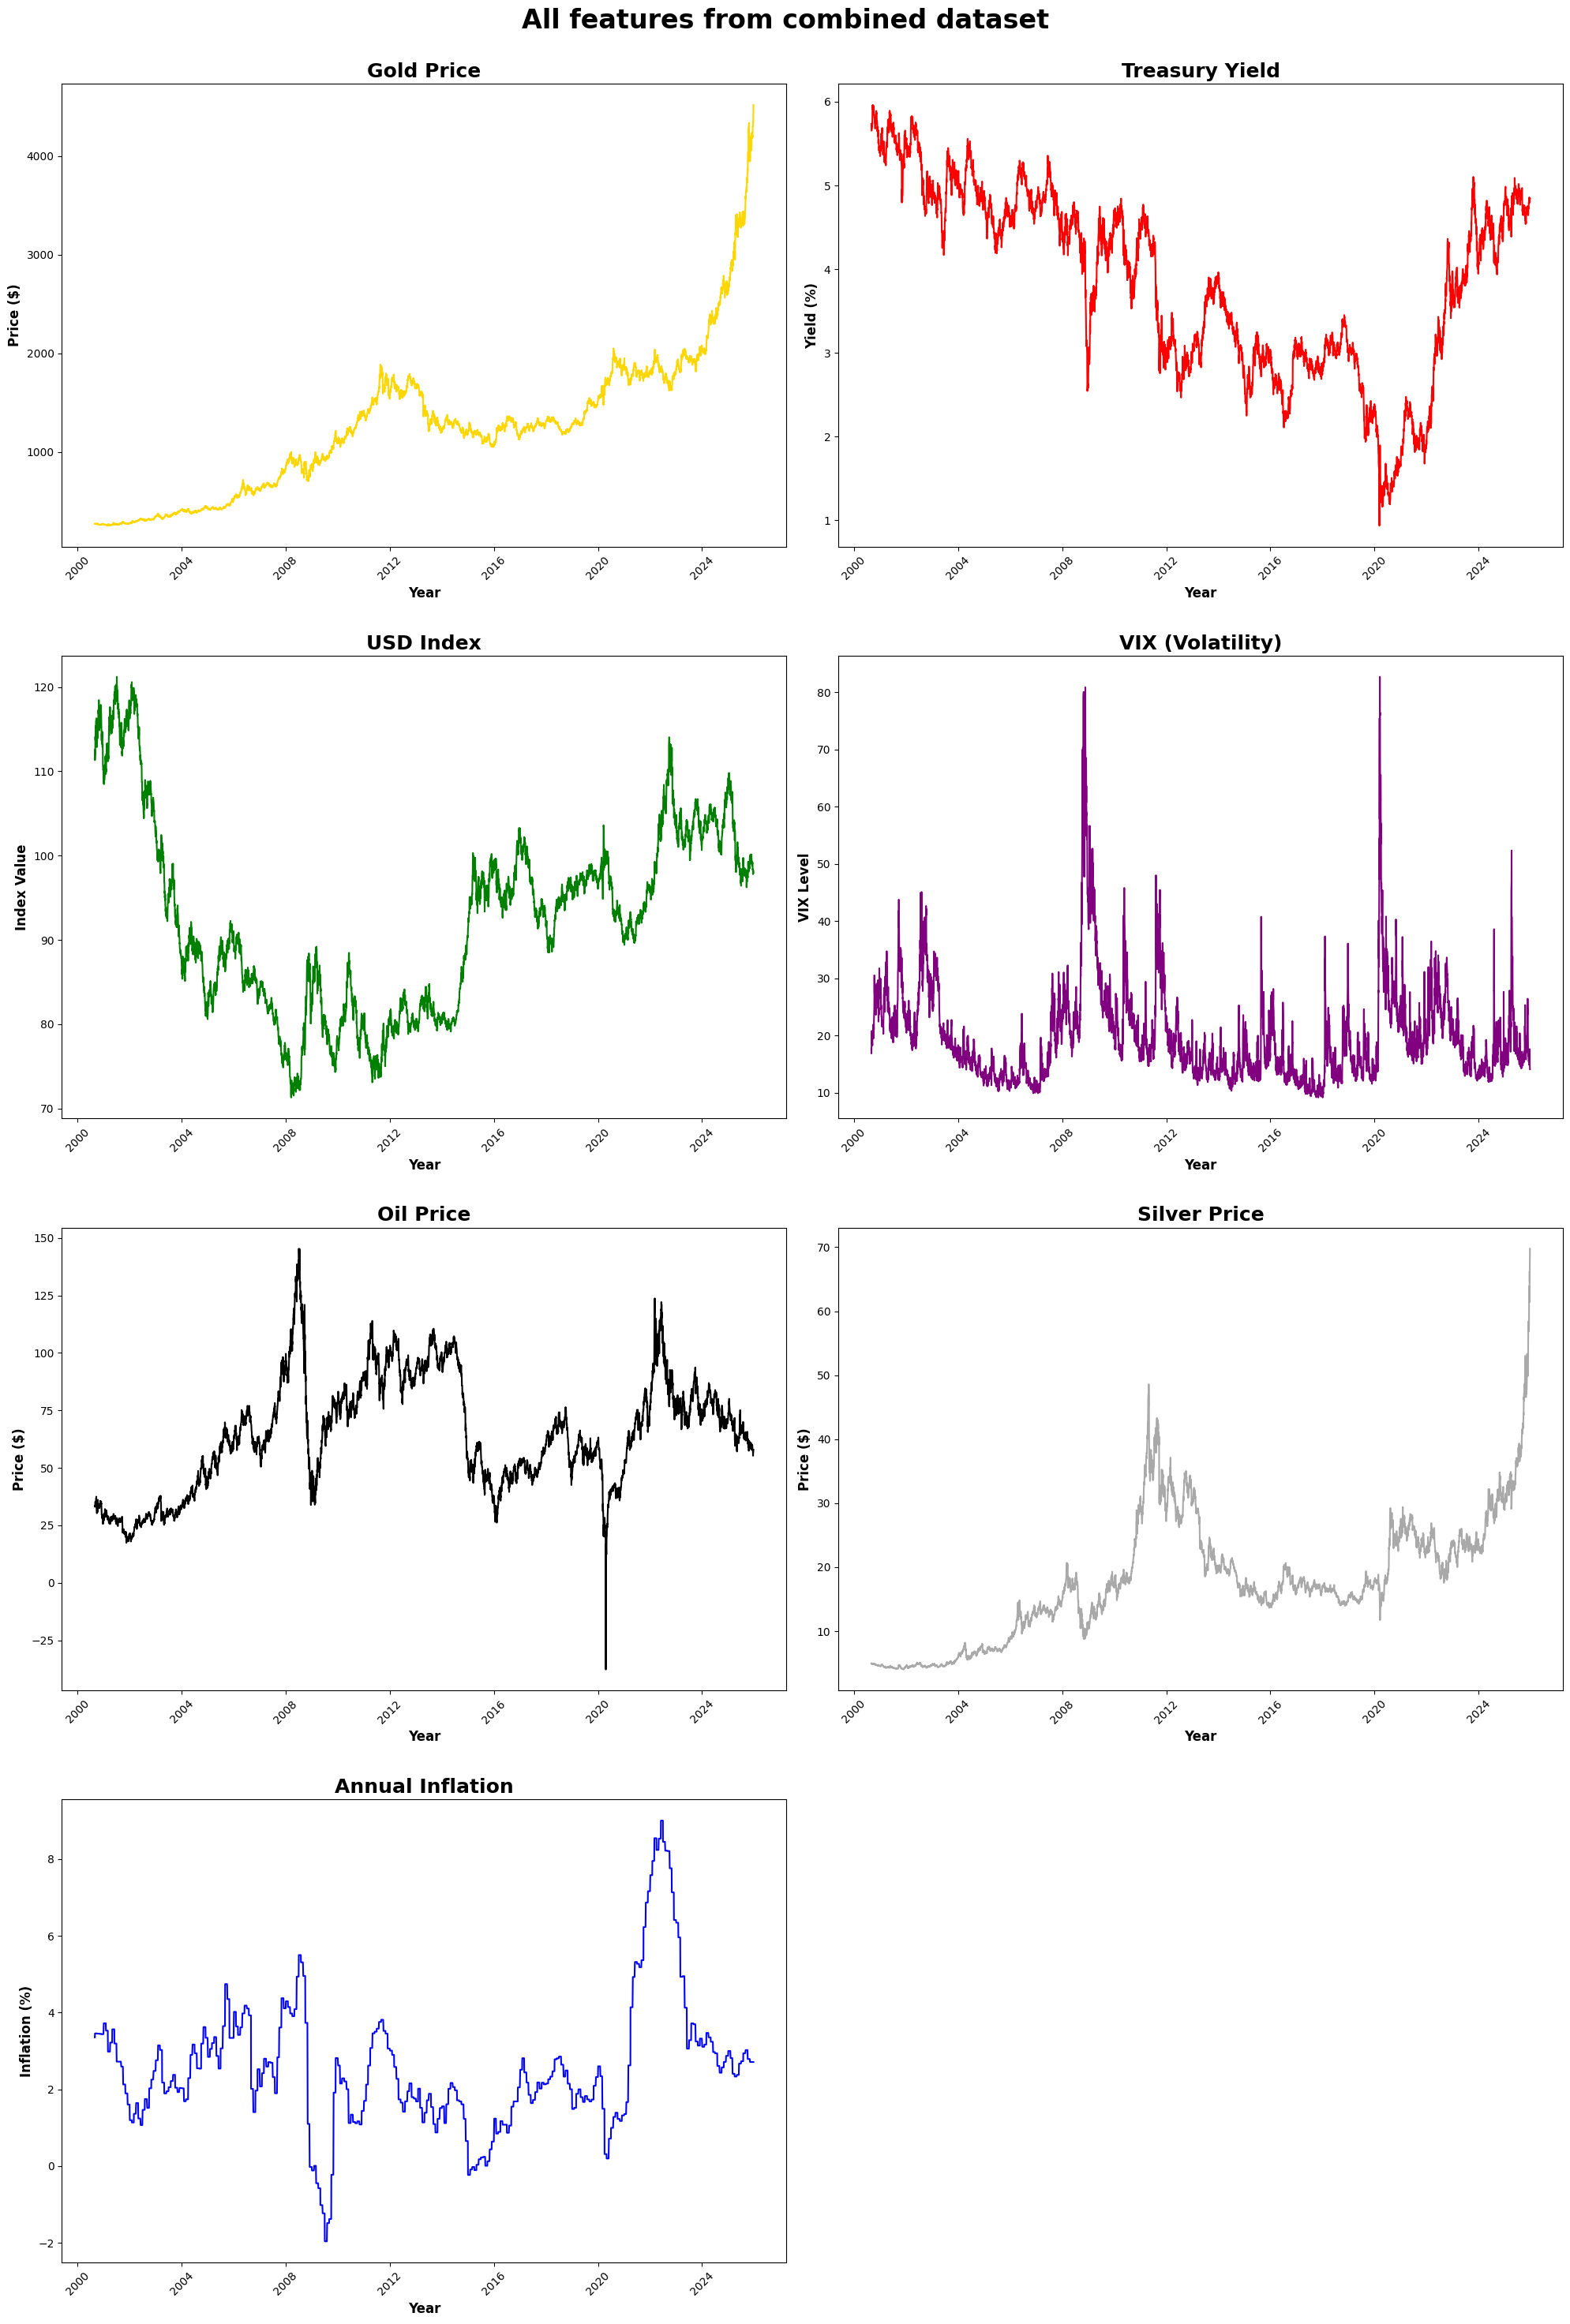

In [11]:
# Function to plot all the features collected in combined dataframe.

def plot_combined_data(combined_df):

    """
    This function helps to plot all the features fromk the dataframe.

    Parameters: combined_df: A combined dataset with all-
                features aligned to daily frequency.

    Returns: None
    """

    # To create a list of features available in the dataframe.
    available_columns = combined_df.columns.tolist()

    # To initialize subplots.
    fig, axes = plt.subplots(4, 2, figsize=(20,30)) # 4 rows, 2 columns, total 8 subplots.
    fig.suptitle('All features from combined dataset\n', fontsize=24, fontweight='bold')
    axes = axes.flatten() # To create 1D array to iterate through subplots easily.

    # To define plot configurations for each variable.
    plot_config = {
        'Gold_Price': {'color': 'gold', 'title': 'Gold Price', 'ylabel': 'Price ($)'},
        'SILVER': {'color': 'darkgray', 'title': 'Silver Price', 'ylabel': 'Price ($)'},
        'OIL': {'color': 'black', 'title': 'Oil Price', 'ylabel': 'Price ($)'},
        'Treasury_yield': {'color': 'red', 'title': 'Treasury Yield', 'ylabel': 'Yield (%)'},
        'USD_Index': {'color': 'green', 'title': 'USD Index', 'ylabel': 'Index Value'},
        'VIX': {'color': 'purple', 'title': 'VIX (Volatility)', 'ylabel': 'VIX Level'},
        'Inflation_Annual': {'color': 'blue', 'title': 'Annual Inflation', 'ylabel': 'Inflation (%)'}
    }

    # To plot subplots for each variables.
    for i, column in enumerate(available_columns):
        if i < len(axes):
            config = plot_config[column]
            axes[i].plot(combined_df.index, combined_df[column], color=config['color'], linewidth=1.5)
            axes[i].set_title('\n' + config['title'], fontweight='bold', fontsize=18)
            axes[i].set_ylabel(config['ylabel'], fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Year', fontsize=12, fontweight='bold')
            axes[i].grid(False)
            axes[i].tick_params(axis='x', rotation=45)

    # To hide unused subplot.
    for i in range(len(available_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_combined_data(combined_df)

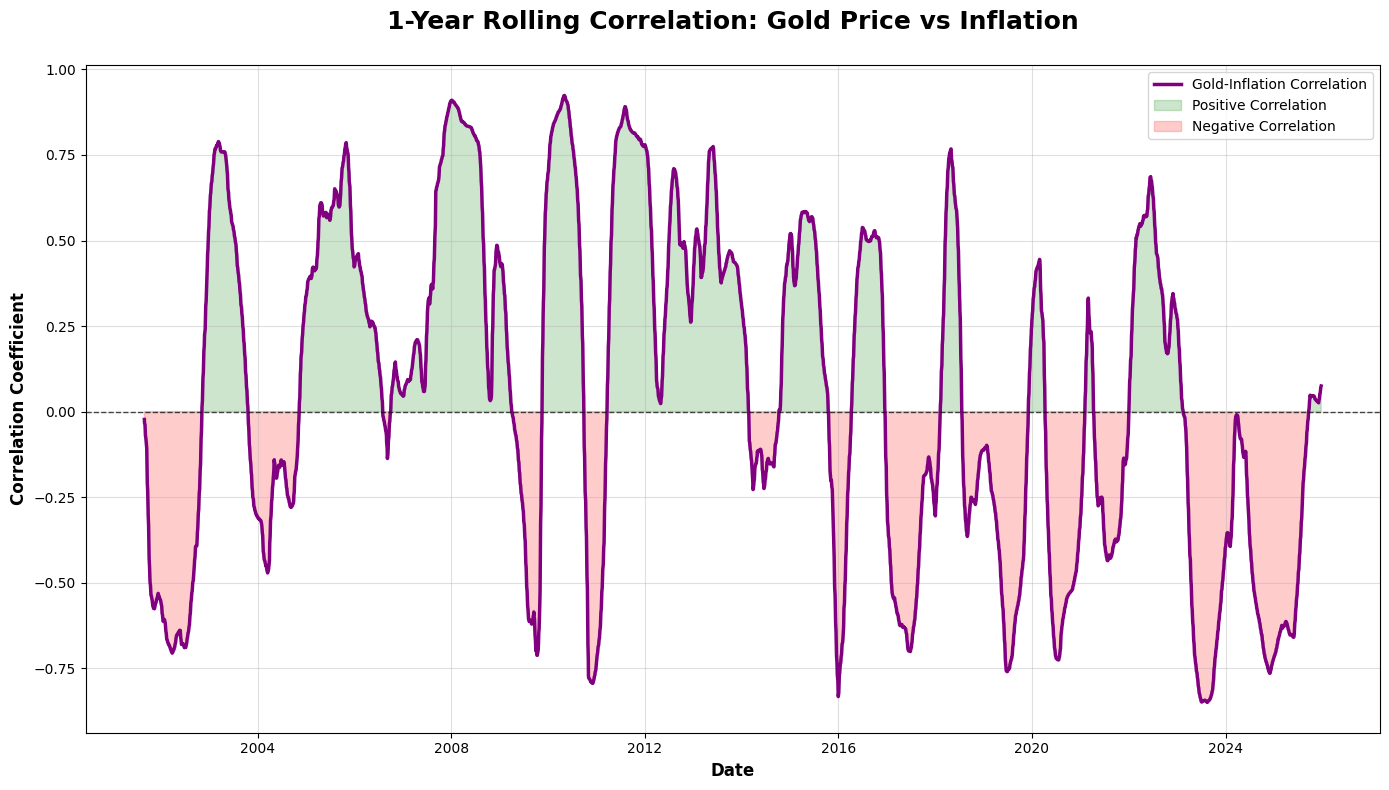

In [12]:
# Function to visualize the correlation between gold and inflation annual.

def plot_gold_inflation_correlation(df):

    """
    This function helps to plot 1-year rolling correlation between Gold Price
    and Inflation Annual.

    Parameters: df = dataframe.
    """

    # To calculate 1-year rolling correlation between gold and inflation.
    # window=252 as there are roughly 252 trading days in a year.
    rolling_corr = df['Gold_Price'].rolling(window=252).corr(df['Inflation_Annual'])

    # To create the correlation plot.
    plt.figure(figsize=(14, 8))
    plt.plot(rolling_corr.index, rolling_corr, color='purple', linewidth=2.5, label='Gold-Inflation Correlation')

    # To add shaded regions for positive/negative correlation.
    plt.fill_between(rolling_corr.index, rolling_corr, 0, where=rolling_corr >= 0,
                     color='green', alpha=0.2, label='Positive Correlation')
    plt.fill_between(rolling_corr.index, rolling_corr, 0, where=rolling_corr <= 0,
                     color='red', alpha=0.2, label='Negative Correlation')

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    plt.title('1-Year Rolling Correlation: Gold Price vs Inflation\n', fontsize=18, fontweight='bold')
    plt.ylabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_gold_inflation_correlation(combined_df)

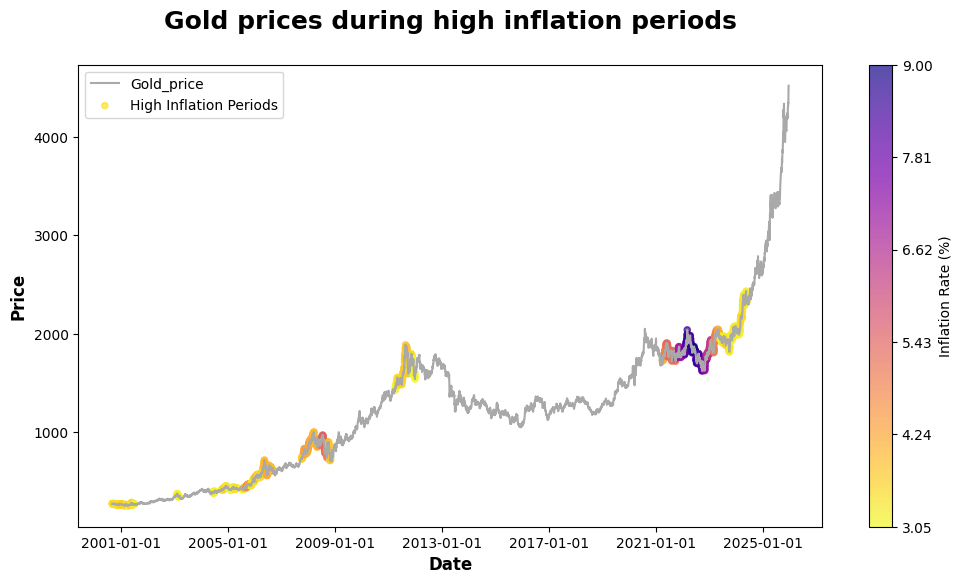

In [13]:
# Function to visualize gold behaviour during high inflation.

def plot_gold_vs_inflation(df):

    """
    This function helps to plot gold prices during high inflation periods.

    Parameters: df = Combined dataset with financial variables

    Returns: high_inflation_periods = DataFrame containing high inflation periods
    """

    high_inflation_threshold = df['Inflation_Annual'].quantile(0.70)
    high_inflation_periods = df[df['Inflation_Annual'] >= high_inflation_threshold]

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Gold_Price'], color='darkgray', label='Gold_price')
    scatter = plt.scatter(high_inflation_periods.index, high_inflation_periods['Gold_Price'],
                         c=high_inflation_periods['Inflation_Annual'], cmap='plasma_r',
                         s=20, alpha=0.7, label='High Inflation Periods')

    # To set the colorbar to threshold.
    vmin = high_inflation_threshold
    vmax = high_inflation_periods['Inflation_Annual'].max()
    scatter.set_clim(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Inflation Rate (%)')
    ticks = [vmin] + list(np.linspace(vmin, vmax, 6)[1:])
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

    plt.title('Gold prices during high inflation periods\n', fontsize=18, fontweight='bold')
    plt.ylabel('Price', fontsize=12, fontweight='bold')
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.legend()
    plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='4YS'))
    plt.show()

    return high_inflation_periods

high_inflation_periods = plot_gold_vs_inflation(combined_df)

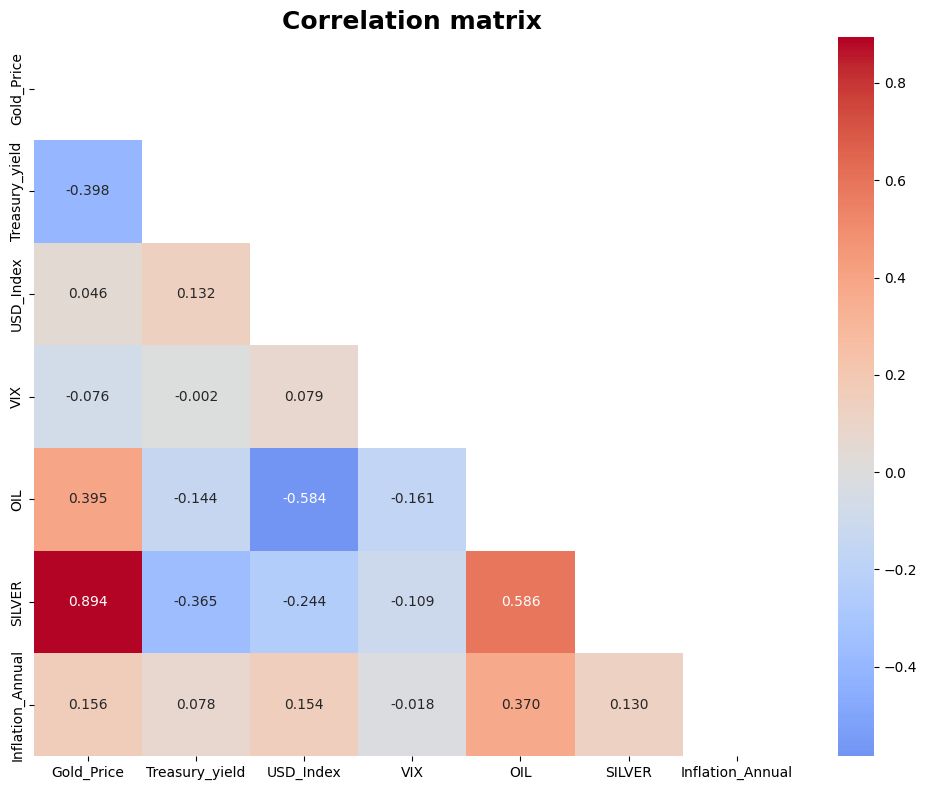

In [14]:
# Function to plot correlation heatmap.

def plot_correlation_heatmap(df, figsize):

    """
    This function helps to plot correlation heatmap for the dataset.

    Parameters: df = dataframe.
                figsize = tuple, Figure size for the heatmap.

    """

    # To calculate correlation matrix of the dataframe.
    corr_matrix = df.corr()

    # To create heatmap using correlation matrix.
    plt.figure(figsize=figsize)

    # To mask the upper triangle for cleaner output.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                fmt='.3f')

    plt.title('Correlation matrix', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

corr_matrix = plot_correlation_heatmap(combined_df,(10,8))

In [15]:
# To check the correlation of all the features with gold.
print("\ncorrelation with gold")
print("=" * 35)
daily_c = combined_df.pct_change().dropna()
correlations = daily_c.corr()['Gold_Price'].sort_values(ascending=False)
print(correlations)


correlation with gold
Gold_Price          1.000000
SILVER              0.776944
OIL                 0.098585
VIX                 0.009694
Inflation_Annual    0.003055
Treasury_yield     -0.138459
USD_Index          -0.410912
Name: Gold_Price, dtype: float64


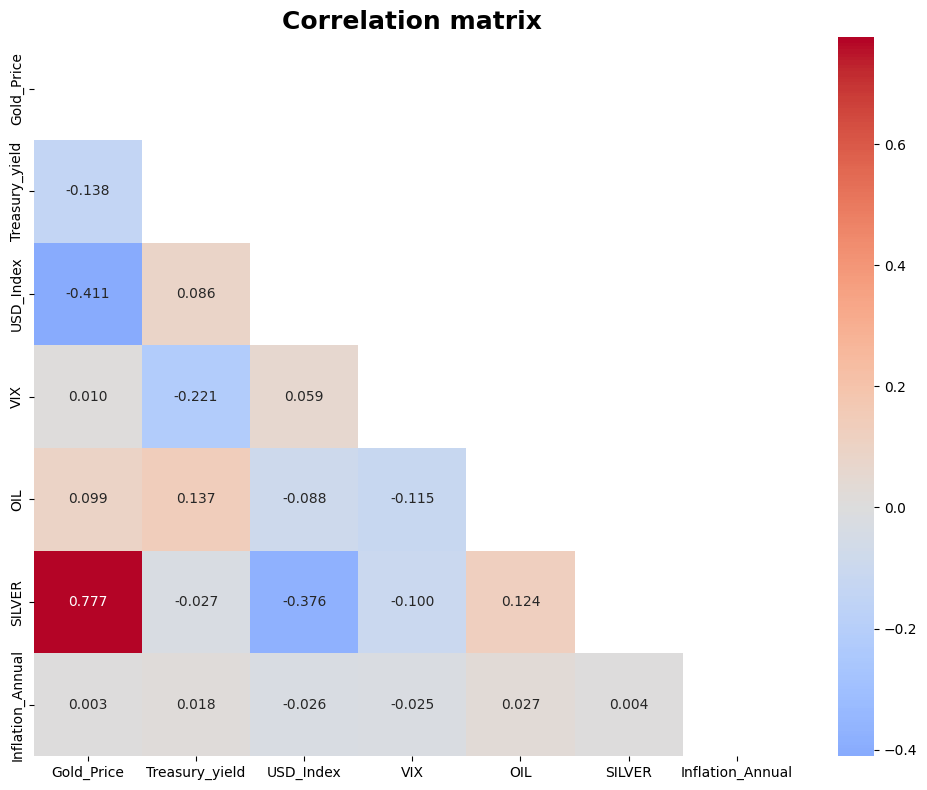

In [16]:
# Function to plot correlation heatmap.

def plot_correlation_heatmap(df, figsize):

    """
    This function helps to plot correlation heatmap for the dataset.

    Parameters: df = dataframe.
                figsize = tuple, Figure size for the heatmap.

    """

    # To calculate correlation matrix of the dataframe.
    corr_matrix = df.corr()

    # To create heatmap using correlation matrix.
    plt.figure(figsize=figsize)

    # To mask the upper triangle for cleaner output.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                fmt='.3f')

    plt.title('Correlation matrix', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

corr_matrix = plot_correlation_heatmap(daily_c,(10,8))

# Step-3 : *Machine Learning.*




* Aim for this machine learning project is to predict gold direction
on weekly basis.
* Model is trained on major (+ and -) correlated features of cobined_df dataframe and some technical indicators which I have created in below functions.







In [17]:
# To install required packages and import libraries.

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             balanced_accuracy_score)
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [18]:
# To create features to train the model.

def create_features(df):

    """
    This function helps to create weekly prediction features from daily data.
    Features are created using only data available up to each Friday.

    Parameters: df = Combined dataset with financial variables

    Returns: data = DataFrame with weekly prediction features
    """

    # To make a copy of the orignal dataframe to avoid modifying it.
    data = df.copy()

    # To creat economic feature of real yield.
    # Real yield calculation based on Federal Reserve research: Gürkaynak, Sack, & Wright (2008)
    data['Real_Yield'] = data['Treasury_yield'] - data['Inflation_Annual']
    data['Real_Yield_Change_5d'] = data['Real_Yield'] - data['Real_Yield'].shift(5)
    data['Real_Yield_Change_10d'] = data['Real_Yield'] - data['Real_Yield'].shift(10)

    # # To create features based on VIX.
    # #
    # To create vix level feature based on VIX prices. (fear level)
    # Low: < 15, Medium: 15-30, High: > 30
    vix_level = pd.cut(data['VIX'], bins=[0, 15, 30, 100], labels=[0, 1, 2])
                                                    # 0=Low, 1=Medium, 2=High
    data['VIX_Level'] = vix_level.astype(float)

    # To create features of percentage changes in price of vix in last 10
    # days.
    data['VIX_Change_10d'] = data['VIX'].pct_change(10)

    # To create feature of vix's current price vs. it's 10 days avrage price.
    data['VIX_vs_10d_Avg'] = data['VIX'] / data['VIX'].rolling(10).mean() - 1

    # # To create features based on ratio of last 5 days between gold and silver,
    # # gold and oil.
    Gold_silver = data['Gold_Price'] / data['SILVER']
    Gold_oil = data['Gold_Price'] / data['OIL']
    Gold_dxy = data['Gold_Price'] / data['USD_Index']
    Gold_yield = data['Gold_Price'] / data['Treasury_yield']
    Gold_ryield = data['Gold_Price'] / data['Real_Yield']

    data['Gold_Silver_Ratio_5d_Avg'] = Gold_silver.rolling(5).mean()
    data['Gold_Yield_Ratio_5d_Avg'] = Gold_yield.rolling(5).mean()
    data['Gold_Real_Yield_Ratio_5d_Avg'] = Gold_ryield.rolling(5).mean()

    # To also get that ratio in percentage.
    data['Gold_DXY_Ratio_Change_5d'] = Gold_dxy.pct_change(5)

    # # To create features based on CPI data (inflation).
    # #
    # Inflation data is publised on monthly basis so we need to detect when it
    # changes in the data.
    # To create a flag for new inflation data.
    data['Inflation_Change_Flag'] = (data['Inflation_Annual'] != data['Inflation_Annual'].shift(1)).astype(int)

    # To create a feature for the monthly inflation change (current vs previous month).
    inflation_changes = data[data['Inflation_Change_Flag'] == 1]['Inflation_Annual'].diff()

    # To forward fill the change values to all days until next update.
    data['Inflation_Actual_Change'] = inflation_changes.reindex(data.index).ffill()

    # # To create features for the 10-day rolling correlation between gold and
    # # DXY, yield, and silver.
    # Gold vs DXY relationship.
    data['Gold_DXY_Corr_10d'] = data['Gold_Price'].pct_change().rolling(10).corr(data['USD_Index'].pct_change())

    # Gold vs Yield relationship.
    data['Gold_Yield_Corr_10d'] = data['Gold_Price'].pct_change().rolling(10).corr(data['Treasury_yield'].pct_change())

    # Gold vs Silver correlation.
    data['Gold_Silver_Corr_10d'] = data['Gold_Price'].pct_change().rolling(10).corr(data['SILVER'].pct_change())

    # To remove unnecessary features.
    data = data.drop(['Inflation_Change_Flag'], axis=1, errors='ignore')

    # To remove NaN values from the data. (created during rolling calculations)
    initial_len = len(data)
    data = data.dropna()
    final_len = len(data)

    print(f"Removed {initial_len - final_len} rows with NaN")
    print(f"Final dataset shape: {data.shape}")
    print(f"Date range after cleaning: {data.index.min()} to {data.index.max()}")
    print(f"Number of features: {len(data.columns)}")

    return data

In [19]:
features_df = create_features(combined_df)

Removed 10 rows with NaN
Final dataset shape: (6328, 21)
Date range after cleaning: 2000-09-14 00:00:00 to 2025-12-22 00:00:00
Number of features: 21


In [20]:
def filter_to_fridays(df):

    """
    This function helps to filter data to Fridays only.

    Parameters: df = Combined dataset with financial variables

    Returns: friday_data = DataFrame with only Fridays

    """

    # To get only Fridays from the data and sort it by date.
    friday_data = df[df.index.dayofweek == 4].copy()
    friday_data = friday_data.sort_index()

    # To get the gold's next week return.
    gold_returns = friday_data['Gold_Price'].pct_change().shift(-1)

    # To create the binary target: 1 if next week's return > 0, else 0. (direction)
    friday_data['Target_Next_Week_Up'] = (gold_returns > 0).astype(int)

    # Here we are working with the current data so we don't have next week's
    # price. So the above direction feature will create a Nan value in the end.
    # To remove the last row.
    friday_data = friday_data.iloc[:-1]

    print(f"Friday Data: {len(friday_data)} weeks")
    print(f"Target: {friday_data['Target_Next_Week_Up'].mean():.1%} Up rate")

    return friday_data

In [21]:
friday_features = filter_to_fridays(features_df)

Friday Data: 1262 weeks
Target: 56.7% Up rate


In [22]:
def prepare_training_data(friday_df):

    """
    This function helps to prepare the data for training.

    Parameters: friday_df = DataFrame with only Fridays.

    Returns: X, y, feature_cols
    """

    # To exclude the raw prices and next week's direction to avoid data leakage.
    exclude_cols = ['Gold_Price', 'SILVER', 'OIL', 'USD_Index', 'VIX',
                   'Treasury_yield', 'Inflation_Annual', 'Target_Next_Week_Up']
    feature_cols = [col for col in friday_df.columns if col not in exclude_cols]

    X = friday_df[feature_cols]
    y = friday_df['Target_Next_Week_Up']

    print(f"Prepared training data:\n")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    return X, y, feature_cols

In [23]:
X, y, feature_cols = prepare_training_data(friday_features)

Prepared training data:

X shape: (1262, 14)
y shape: (1262,)
Number of features: 14
Target distribution: {1: 715, 0: 547}


In [24]:
def time_based_split(X, y, test_size):

    """
    This function helps to split data into train and test.

    Parameters: X = DataFrame with features.
                y = target.
                test_size = float, Proportion of data to be used for testing.

    Returns: X_train = DataFrame with training features.
             X_test = DataFrame with testing features.
             y_train = Training targets.
             y_test = Testing targets.
    """

    split_point = int(len(X) * (1 - test_size))

    X_train = X.iloc[:split_point]
    X_test = X.iloc[split_point:]
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    print(f"\nTime-based split:")
    print(f"Training period: {X_train.index.min().date()} to {X_train.index.max().date()}")
    print(f"Testing period: {X_test.index.min().date()} to {X_test.index.max().date()}")
    print(f"Train samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    return X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = time_based_split(X, y, test_size=0.2)


Time-based split:
Training period: 2000-09-15 to 2020-12-04
Testing period: 2020-12-11 to 2025-12-12
Train samples: 1009
Test samples: 253


In [26]:
def select_best_features(X_train, X_test, y_train, k):

    """
    This function helps to select the most predictive features for forecasting
    whether gold prices will go up or down next week. It uses statistical analysis
    to filter out noise and keep only the strongest predictors.

    Parameters: X_train : DataFrame with training features.
                X_test : DataFrame with test features.
                y_train : Training target variable.
                k : Number of features to select (top k).

    Returns: X_train_selected : DataFrame with training data with selected features.
             X_test_selected : DataFrame with test data with selected features.
             selected_features : List of selected feature names.
             feature_scores : All features with their scores.
    """
    # To select the best features from training dataset using SelectKBest with
    # f_classif which analyses each feature based on their score of how well
    # they are able to seprate the up and down weeks.
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train, y_train)

    # To get selected features.
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask].tolist()

    # To modify train and test data based on this selected features.
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    print(f"Selected top {k} features:\n")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i:2d}. {feat}")

    return X_train_selected, X_test_selected, selected_features

In [27]:
X_train_selected, X_test_selected, selected_features = select_best_features(
        X_train, X_test, y_train, k=14)

Selected top 14 features:

 1. Real_Yield
 2. Real_Yield_Change_5d
 3. Real_Yield_Change_10d
 4. VIX_Level
 5. VIX_Change_10d
 6. VIX_vs_10d_Avg
 7. Gold_Silver_Ratio_5d_Avg
 8. Gold_Yield_Ratio_5d_Avg
 9. Gold_Real_Yield_Ratio_5d_Avg
10. Gold_DXY_Ratio_Change_5d
11. Inflation_Actual_Change
12. Gold_DXY_Corr_10d
13. Gold_Yield_Corr_10d
14. Gold_Silver_Corr_10d


In [28]:
def scale_features(X_train, X_test):

    """
    This function helps to normalize features using standardScaler.

    Parameters: X_train = DataFrame with training features.
                X_test : DataFrame with test features.

    Returns: X_train_scaled = DataFrame with scaled training data.
             X_test_scaled = DataFrame with scaled test data.
             scaler = Standardscaler with trained scaler object.
    """

    # To initialize the scaler.
    scaler = StandardScaler()

    # To fit the scaler on training data only and transform it to both traning
    # and testing data. on training data and transform both.
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # To convert scaled arrays back to DataFrames with original column names and
    # dates. StandardScaler.fit_transform() returns numpy arrays, losing feature
    # names and timestamps. We need DataFrames for proper model training and
    # evaluation
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns,
                                  index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns,
                                  index=X_test.index)

    print(f"Features scaled using StandardScaler")

    return X_train_scaled, X_test_scaled, scaler

In [30]:
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
X_train_selected, X_test_selected, selected_features = select_best_features(
        X_train_scaled, X_test_scaled, y_train, k=14)
X_train_scaled = X_train_selected
X_test_scaled =  X_test_selected

Features scaled using StandardScaler
Selected top 14 features:

 1. Real_Yield
 2. Real_Yield_Change_5d
 3. Real_Yield_Change_10d
 4. VIX_Level
 5. VIX_Change_10d
 6. VIX_vs_10d_Avg
 7. Gold_Silver_Ratio_5d_Avg
 8. Gold_Yield_Ratio_5d_Avg
 9. Gold_Real_Yield_Ratio_5d_Avg
10. Gold_DXY_Ratio_Change_5d
11. Inflation_Actual_Change
12. Gold_DXY_Corr_10d
13. Gold_Yield_Corr_10d
14. Gold_Silver_Corr_10d


**Training and testing models**

In [31]:
def perform_time_series_cv(model, X_train, y_train, model_name="Model", n_splits=5):

    """
    This function performs time series cross-validation for any model and returns
    the cross-validation scores.

    Parameters: model : Any machine learning model.
                X_train : DataFrame with training features.
                y_train : Series with training target values.
                model_name : Name of the model for display purposes.
                n_splits : Number of folds for cross-validation.

    Returns: cv_scores : Dictionary with cross-validation metrics.

    """
    print(f"\n Performing {n_splits}-fold Time Series Cross-Validation for {model_name}:")

    # To configure time series cross-validation.
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # To store cross-validation metrics for each fold.
    cv_train_accs = []
    cv_val_accs = []
    cv_f1_scores = []
    cv_bal_accs = []
    cv_precisions = []
    cv_recalls = []

    # To iterate through each fold of cross-validation.
    for fold, (train_i, val_i) in enumerate(tscv.split(X_train), 1):

        # To split data into training and validation for current fold.
        X_tr = X_train.iloc[train_i]
        X_val = X_train.iloc[val_i]
        y_tr = y_train.iloc[train_i]
        y_val = y_train.iloc[val_i]

        # To train model on training fold.
        model.fit(X_tr, y_tr)

        # To make predictions on training and validation data.
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        # To calculate performance metrics for current fold.
        train_acc = accuracy_score(y_tr, y_tr_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, zero_division=0)
        bal_acc = balanced_accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, zero_division=0)
        recall = recall_score(y_val, y_val_pred, zero_division=0)

        # To store metrics for current fold.
        cv_train_accs.append(train_acc)
        cv_val_accs.append(val_acc)
        cv_f1_scores.append(f1)
        cv_bal_accs.append(bal_acc)
        cv_precisions.append(precision)
        cv_recalls.append(recall)

        print(f"   Fold {fold}/{n_splits}: Train={train_acc:.4f}, Val={val_acc:.4f}, "
                  f"BalAcc={bal_acc:.4f}, F1={f1:.4f}")

    # To calculate mean performance across all folds.
    mean_train = np.mean(cv_train_accs)
    mean_val = np.mean(cv_val_accs)
    mean_f1 = np.mean(cv_f1_scores)
    mean_bal = np.mean(cv_bal_accs)
    mean_precision = np.mean(cv_precisions)
    mean_recall = np.mean(cv_recalls)
    std_val = np.std(cv_val_accs)
    gap = mean_train - mean_val

    # To print cross-validation summary results.
    print("\n Cross-Validation Summary:")
    print(f"    Mean Train Accuracy:     {mean_train:.4f}")
    print(f"    Mean Val Accuracy:       {mean_val:.4f} (±{std_val:.4f})")
    print(f"    Mean Balanced Accuracy:  {mean_bal:.4f}")
    print(f"    Mean F1 Score:           {mean_f1:.4f}")
    print(f"    Mean Precision:          {mean_precision:.4f}")
    print(f"    Mean Recall:             {mean_recall:.4f}")
    print(f"    Train-Val Gap:           {gap:.4f}", end=" ")

    # To provide interpretation of overfitting gap.
    if gap < 0.05:
        print(" Excellent generalization!")
    elif gap < 0.15:
        print(" Good generalization")
    else:
        print(" Overfitting detected")

    # To store cross-validation scores in dictionary.
    cv_scores = {
        'train_acc': mean_train,
        'val_acc': mean_val,
        'balanced_acc': mean_bal,
        'f1': mean_f1,
        'precision': mean_precision,
        'recall': mean_recall,
        'std': std_val,
        'gap': gap
    }

    return cv_scores

In [32]:
def evaluate_model_generic(model, X_train, X_test, y_train, y_test, model_name="Model"):

    """
    This function provides generic evaluation for any model.

    Parameters: model : Any sklearn model with fit/predict methods.
                X_train : DataFrame with training features.
                X_test : DataFrame with test features.
                y_train : Series with training target values.
                y_test : Series with test target values.
                model_name : Name of the model for display purposes.

    Returns: results : Dictionary containing all evaluation metrics.
    """

    print(f"\nModel evalution for {model_name.upper()}")

    # To get model predictions for training and test data.
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # To calculate various performance metrics.
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=0)
    recall = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)

    # To print the calculated performance metrics.
    print("\n Performance Metrics:")
    print(f"    Training Accuracy:       {train_acc:.4f}")
    print(f"    Test Accuracy:           {test_acc:.4f}")
    print(f"    Balanced Accuracy:       {test_bal_acc:.4f}")
    print(f"    Precision:               {precision:.4f}")
    print(f"    Recall:                  {recall:.4f}")
    print(f"    F1 Score:                {f1:.4f}")

    # To check for overfitting by comparing training and test accuracy.
    gap = train_acc - test_acc
    print("\n Generalization Analysis:")
    print(f"   Train-Test Gap:          {gap:+.4f}", end=" ")

    # To provide interpretation of the overfitting gap.
    if gap < 0.05:
        print(" Excellent generalization!")
    elif gap < 0.15:
        print(" Good generalization")
    else:
        print(" Overfitting detected")

    # To create and display the confusion matrix.
    cm = confusion_matrix(y_test, y_test_pred)
    print("\n Confusion Matrix:")
    print("                     Predicted Down  Predicted Up")
    print(f"      Actual Down         {cm[0,0]:4d}          {cm[0,1]:4d}")
    print(f"      Actual Up           {cm[1,0]:4d}          {cm[1,1]:4d}")

    # To calculate per-class accuracy for detailed analysis.
    print("\n Per-Class Performance:")
    down_total = cm[0,0] + cm[0,1]
    up_total = cm[1,0] + cm[1,1]

    # To calculate accuracy for down weeks.
    if down_total > 0:
        down_acc = cm[0,0] / down_total
        print(f"    Down weeks:  {cm[0,0]:3d}/{down_total:3d} correct ({down_acc:.1%})")

    # To calculate accuracy for up weeks.
    if up_total > 0:
        up_acc = cm[1,1] / up_total
        print(f"    Up weeks:    {cm[1,1]:3d}/{up_total:3d} correct ({up_acc:.1%})")

    # Try to get feature importance if available
    feature_importance = None
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
    elif hasattr(model, 'coef_'):
        # For linear models
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_,
            'Abs_Coefficient': abs(model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)

    # To store all results in a dictionary for further use.
    results = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'balanced_acc': test_bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'gap': gap,
        'confusion_matrix': cm,
        'feature_importance': feature_importance}

    if feature_importance is not None:
        print(f"\n  Top 5 Most Important Features:")
        for i in range(min(5, len(feature_importance))):
            feat = feature_importance.iloc[i]
            if 'Coefficient' in feat:
                direction = "UP" if feat['Coefficient'] > 0 else "DOWN"
                print(f"   {i+1:2d}. {feat['Feature']:30s}: {feat['Coefficient']:+.4f} (predicts {direction})")
            else:
                print(f"   {i+1:2d}. {feat['Feature']:30s}: {feat['Importance']:.4f}")

    return results

In [33]:
def train_model_generic(model, X_train, y_train, X_test, y_test, model_name="Model"):

    """
    This is a complete generic training pipeline for any model.

    Parameters: model : Any sklearn model.
                X_train, y_train : Training data.
                X_test, y_test : Test data.
                model_name : Name for display.

    Returns: trained_model : Trained model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*80}")

    # Step 1: Cross-validation
    cv_scores = perform_time_series_cv(model, X_train, y_train, model_name)

    # Step 2: Train final model on full training set
    print(f"\n Training Final Model on Full Training Set...")
    model.fit(X_train, y_train)
    print(f"    {model_name} training complete!")

    # Step 3: Evaluate on test set
    results = evaluate_model_generic(model, X_train, X_test, y_train, y_test, model_name)

    # Step 4: Print summary
    print(f"\n{model_name.upper()} SUMMARY")
    print(f"{'='*80}")
    print(f"    Test Accuracy:        {results['test_acc']:.4f}")
    print(f"    Balanced Accuracy:    {results['balanced_acc']:.4f}")
    print(f"    F1 Score:             {results['f1']:.4f}")
    print(f"    Precision:            {results['precision']:.4f}")
    print(f"    Recall:               {results['recall']:.4f}")
    print(f"    Overfitting Gap:      {results['gap']:.4f}")

    return model, cv_scores, results

- Logistic regression

In [34]:
def train_logistic_regression(X_train, y_train, X_test, y_test):

    """
    This function trains a Logistic Regression model.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.

    Returns: model : Trained Logistic Regression model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    # To initialize the model with specified parameters.
    model = LogisticRegression(C=0.01,
                               penalty='l2',
                               max_iter=1000,
                               random_state=42,
                               solver='lbfgs')

    # To use the generic training pipeline.
    model, cv_scores, results = train_model_generic(model, X_train, y_train,
                                                    X_test, y_test, "Logistic Regression")

    return model, cv_scores, results

In [35]:
model_lr, cv_lr, results_lr = train_logistic_regression(X_train_scaled, y_train,
                                                        X_test_scaled, y_test)

TRAINING LOGISTIC REGRESSION

 Performing 5-fold Time Series Cross-Validation for Logistic Regression:
   Fold 1/5: Train=0.5740, Val=0.6250, BalAcc=0.5032, F1=0.7675
   Fold 2/5: Train=0.5757, Val=0.5536, BalAcc=0.4639, F1=0.7059
   Fold 3/5: Train=0.5842, Val=0.5536, BalAcc=0.5013, F1=0.7104
   Fold 4/5: Train=0.5706, Val=0.4881, BalAcc=0.5040, F1=0.6417
   Fold 5/5: Train=0.5565, Val=0.3869, BalAcc=0.3903, F1=0.3977

 Cross-Validation Summary:
    Mean Train Accuracy:     0.5722
    Mean Val Accuracy:       0.5214 (±0.0800)
    Mean Balanced Accuracy:  0.4725
    Mean F1 Score:           0.6446
    Mean Precision:          0.5390
    Mean Recall:             0.8349
    Train-Val Gap:           0.0507  Good generalization

 Training Final Model on Full Training Set...
    Logistic Regression training complete!

Model evalution for LOGISTIC REGRESSION

 Performance Metrics:
    Training Accuracy:       0.5619
    Test Accuracy:           0.6047
    Balanced Accuracy:       0.5222
    

In [36]:
def tune_logistic_regression(X_train, y_train, X_test, y_test):

    """
    This function performs hyperparameter tuning for Logistic Regression.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.
    Returns: best_model : Best Logistic Regression model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    # To define the parameter grid for ALL parameters
    param_grid = {'C': [0.011, 0.057, 0.113],
                  'penalty': ['l1', 'l2'],
                  'max_iter': [500, 1000],
                  'fit_intercept': [True],
                  'class_weight': [None, 'balanced', {0: 1, 1: 1.1}, {0: 1.1, 1: 1}],
                  'random_state': [42, 123],
                  'solver': ['lbfgs', 'newton-cg']}

    # To configure time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # To create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                               param_grid=param_grid,
                               cv=tscv,
                               scoring='balanced_accuracy',
                               n_jobs=-1,
                               verbose=1,
                               refit=True)

    # To execute grid search
    print(f"Tuning Logistic Regression...")
    grid_search.fit(X_train, y_train)

    # To get best model and ALL parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters Found:")
    print(f"  C: {best_params.get('C')}")
    print(f"  penalty: {best_params.get('penalty')}")
    print(f"  max_iter: {best_params.get('max_iter')}")
    print(f"  fit_intercept: {best_params.get('fit_intercept')}")
    print(f"  class_weight: {best_params.get('class_weight')}")
    print(f"  random_state: {best_params.get('random_state')}")
    print(f"  solver: {best_params.get('solver')}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")

    # Use the generic training pipeline with tuned model
    model, cv_scores, results = train_model_generic(best_model, X_train, y_train,
                                                    X_test, y_test, "Tuned Logistic Regression")

    return model, cv_scores, results

In [37]:
results_dict = {}

In [38]:
lr_model, lr_cv, lr_results = tune_logistic_regression(X_train, y_train, X_test, y_test)
results_dict['Logistic Regression'] = {'model': lr_model,
                                       'cv_scores': lr_cv,
                                       'results': lr_results}

Tuning Logistic Regression...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters Found:
  C: 0.011
  penalty: l2
  max_iter: 500
  fit_intercept: True
  class_weight: {0: 1.1, 1: 1}
  random_state: 42
  solver: newton-cg
Best CV Score: 0.5080
TRAINING TUNED LOGISTIC REGRESSION

 Performing 5-fold Time Series Cross-Validation for Tuned Logistic Regression:
   Fold 1/5: Train=0.5385, Val=0.4048, BalAcc=0.5238, F1=0.0909
   Fold 2/5: Train=0.5935, Val=0.5952, BalAcc=0.5303, F1=0.7143
   Fold 3/5: Train=0.5921, Val=0.5357, BalAcc=0.4852, F1=0.6953
   Fold 4/5: Train=0.5795, Val=0.4940, BalAcc=0.5009, F1=0.5685
   Fold 5/5: Train=0.5612, Val=0.4405, BalAcc=0.5000, F1=0.0000

 Cross-Validation Summary:
    Mean Train Accuracy:     0.5729
    Mean Val Accuracy:       0.4940 (±0.0676)
    Mean Balanced Accuracy:  0.5080
    Mean F1 Score:           0.4138
    Mean Precision:          0.5308
    Mean Recall:             0.5059
    Train-Val Gap:           0.0789  Goo

- Ridge classifier

In [39]:
def train_ridge_classifier(X_train, y_train, X_test, y_test):

    """
    This function trains a Ridge Classifier model.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.

    Returns: model : Trained Ridge Classifier model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    # To initialize the Ridge Classifier model.
    model = RidgeClassifier(alpha=10,
                            solver='svd',
                            random_state=42,
                            class_weight='balanced')

    # To use the generic training pipeline.
    model, cv_scores, results = train_model_generic(model, X_train, y_train,
                                                    X_test, y_test, "Ridge Classifier")

    return model, cv_scores, results

In [40]:
model_ridge, cv_ridge, results_ridge = train_ridge_classifier(X_train_scaled, y_train,
                                                              X_test_scaled, y_test)

TRAINING RIDGE CLASSIFIER

 Performing 5-fold Time Series Cross-Validation for Ridge Classifier:
   Fold 1/5: Train=0.6509, Val=0.5952, BalAcc=0.5048, F1=0.7280
   Fold 2/5: Train=0.5757, Val=0.5179, BalAcc=0.5602, F1=0.4774
   Fold 3/5: Train=0.5604, Val=0.4702, BalAcc=0.4363, F1=0.6114
   Fold 4/5: Train=0.5527, Val=0.5238, BalAcc=0.5185, F1=0.4286
   Fold 5/5: Train=0.5577, Val=0.4286, BalAcc=0.4850, F1=0.0204

 Cross-Validation Summary:
    Mean Train Accuracy:     0.5795
    Mean Val Accuracy:       0.5071 (±0.0560)
    Mean Balanced Accuracy:  0.5010
    Mean F1 Score:           0.4532
    Mean Precision:          0.5198
    Mean Recall:             0.4726
    Train-Val Gap:           0.0723  Good generalization

 Training Final Model on Full Training Set...
    Ridge Classifier training complete!

Model evalution for RIDGE CLASSIFIER

 Performance Metrics:
    Training Accuracy:       0.5173
    Test Accuracy:           0.5257
    Balanced Accuracy:       0.5468
    Precision:  

In [41]:
def tune_ridge_classifier(X_train, y_train, X_test, y_test):

    """
    This function performs hyperparameter tuning for Ridge Classifier.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.
    Returns: best_model : Best Ridge Classifier model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    # To define the parameter grid for ALL parameters
    param_grid = {'alpha': [50, 100, 500],
                  'solver': ['svd', 'cholesky'],
                  'fit_intercept': [True, False],
                  'copy_X': [True, False],
                  'random_state': [42, 123, 456, 789],
                  'class_weight': [None, 'balanced', {0: 1, 1: 1.1}, {0: 1.1, 1: 1}]}

    # To configure time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # To create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=RidgeClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=tscv,
                               scoring='balanced_accuracy',
                               n_jobs=-1,
                               verbose=1,
                               refit=True)

    # To execute grid search
    print(f"Tuning Ridge Classifier...")
    grid_search.fit(X_train, y_train)

    # To get best model and ALL parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters Found:")
    print(f"  alpha: {best_params.get('alpha')}")
    print(f"  solver: {best_params.get('solver')}")
    print(f"  fit_intercept: {best_params.get('fit_intercept')}")
    print(f"  copy_X: {best_params.get('copy_X')}")
    print(f"  class_weight: {best_params.get('class_weight')}")
    print(f"  random_state: {best_params.get('random_state')}")
    print(f"  Best CV Score: {grid_search.best_score_:.4f}")

    # Use the generic training pipeline with tuned model
    model, cv_scores, results = train_model_generic(best_model, X_train, y_train,
                                                    X_test, y_test, "Tuned Ridge Classifier")

    return model, cv_scores, results

In [42]:
ridge_model, ridge_cv, ridge_results = tune_ridge_classifier(X_train, y_train, X_test, y_test)
results_dict['Ridge Classifier'] = {'model': ridge_model,
                                    'cv_scores': ridge_cv,
                                    'results': ridge_results}

Tuning Ridge Classifier...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best Parameters Found:
  alpha: 500
  solver: svd
  fit_intercept: True
  copy_X: True
  class_weight: {0: 1.1, 1: 1}
  random_state: 42
  Best CV Score: 0.5082
TRAINING TUNED RIDGE CLASSIFIER

 Performing 5-fold Time Series Cross-Validation for Tuned Ridge Classifier:
   Fold 1/5: Train=0.5266, Val=0.4048, BalAcc=0.5238, F1=0.0909
   Fold 2/5: Train=0.5875, Val=0.5893, BalAcc=0.5227, F1=0.7113
   Fold 3/5: Train=0.5921, Val=0.5417, BalAcc=0.4905, F1=0.7004
   Fold 4/5: Train=0.5780, Val=0.5000, BalAcc=0.5040, F1=0.5435
   Fold 5/5: Train=0.5660, Val=0.4405, BalAcc=0.5000, F1=0.0000

 Cross-Validation Summary:
    Mean Train Accuracy:     0.5700
    Mean Val Accuracy:       0.4952 (±0.0666)
    Mean Balanced Accuracy:  0.5082
    Mean F1 Score:           0.4092
    Mean Precision:          0.5309
    Mean Recall:             0.4932
    Train-Val Gap:           0.0748  Good generalization

 Traini

- Random forest

In [44]:
def train_random_forest(X_train, y_train, X_test, y_test):

    """
    Refactored version using generic functions for Random Forest.
    Uses conservative parameters to prevent overfitting for time series data.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.

    Returns: model : Trained Random Forest model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    model = RandomForestClassifier(n_estimators=50,
                                   max_depth=3,
                                   min_samples_split=30,
                                   min_samples_leaf=15,
                                   max_features=0.3,
                                   max_samples=0.7,
                                   bootstrap=True,
                                   oob_score=True,
                                   random_state=42,
                                   n_jobs=-1,
                                   verbose=0)

    # Use the generic training pipeline
    model, cv_scores, results = train_model_generic(model, X_train, y_train,
                                                    X_test, y_test, "Random Forest")

    return model, cv_scores, results

In [45]:
model_rf, cv_rf, results_rf = train_random_forest(X_train_scaled, y_train,
                                                  X_test_scaled, y_test)

TRAINING RANDOM FOREST

 Performing 5-fold Time Series Cross-Validation for Random Forest:
   Fold 1/5: Train=0.7515, Val=0.5655, BalAcc=0.5444, F1=0.6439
   Fold 2/5: Train=0.6647, Val=0.5952, BalAcc=0.4902, F1=0.7463
   Fold 3/5: Train=0.6158, Val=0.5476, BalAcc=0.4959, F1=0.7054
   Fold 4/5: Train=0.6226, Val=0.5119, BalAcc=0.5241, F1=0.6306
   Fold 5/5: Train=0.6243, Val=0.4821, BalAcc=0.4884, F1=0.4852

 Cross-Validation Summary:
    Mean Train Accuracy:     0.6558
    Mean Val Accuracy:       0.5405 (±0.0397)
    Mean Balanced Accuracy:  0.5086
    Mean F1 Score:           0.6423
    Mean Precision:          0.5714
    Mean Recall:             0.7776
    Train-Val Gap:           0.1153  Good generalization

 Training Final Model on Full Training Set...
    Random Forest training complete!

Model evalution for RANDOM FOREST

 Performance Metrics:
    Training Accuracy:       0.6135
    Test Accuracy:           0.5771
    Balanced Accuracy:       0.5064
    Precision:              

In [ ]:
'''
param_grid = {'max_depth': [1, 2, 3],
                  'min_samples_split': [5, 10, 15],
                  'min_samples_leaf': [2, 4, 6],
                  'max_features': [0.2, 0.3],
                  'max_samples': [0.4, 0.6],
                  'class_weight': [None, 'balanced', {0: 1, 1: 1.1}, {0: 1.1, 1: 1}]}
'''

In [48]:
def tune_random_forest(X_train, y_train, X_test, y_test):

    """
    This function performs hyperparameter tuning for Random Forest.

    Parameters: X_train, y_train : Training data.
                X_test, y_test : Test data.
    Returns: best_model : Best Random Forest model.
             cv_scores : Cross-validation scores.
             results : Test evaluation results.
    """

    # To define the parameter grid for key Random Forest parameters
    param_grid = {'n_estimators': [100, 200],
                  'max_depth': [3, 5],
                  'min_samples_split': [5, 10],
                  'min_samples_leaf': [2, 4],
                  'max_features': [0.2],
                  'criterion': ['entropy'],
                  'class_weight': [None, 'balanced', {0: 1, 1: 1.1}, {0: 1.1, 1: 1}]}

    # To configure time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # To create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=tscv,
                               scoring='balanced_accuracy',
                               n_jobs=-1,
                               verbose=1,
                               refit=True)

    # To execute grid search
    print(f"Tuning Random Forest...")
    grid_search.fit(X_train, y_train)

    # To get best model and ALL parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters Found:")
    print(f"  n_estimators: {best_params.get('n_estimators')}")
    print(f"  max_depth: {best_params.get('max_depth')}")
    print(f"  min_samples_split: {best_params.get('min_samples_split')}")
    print(f"  min_samples_leaf: {best_params.get('min_samples_leaf')}")
    print(f"  max_features: {best_params.get('max_features')}")
    print(f"  class_weight: {best_params.get('class_weight')}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")

    # Use the generic training pipeline with tuned model
    model, cv_scores, results = train_model_generic(best_model, X_train, y_train,
                                                    X_test, y_test, "Tuned Random Forest")

    return model, cv_scores, results

In [47]:
rf_model, rf_cv, rf_results = tune_random_forest(X_train, y_train, X_test, y_test)
results_dict['Random Forest'] = {'model': rf_model,
                                 'cv_scores': rf_cv,
                                 'results': rf_results}

Tuning Random Forest...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters Found:
  n_estimators: 100
  max_depth: 3
  min_samples_split: 5
  min_samples_leaf: 4
  max_features: 0.2
  class_weight: {0: 1.1, 1: 1}
Best CV Score: 0.4976
TRAINING TUNED RANDOM FOREST

 Performing 5-fold Time Series Cross-Validation for Tuned Random Forest:
   Fold 1/5: Train=0.8521, Val=0.3750, BalAcc=0.4746, F1=0.1322
   Fold 2/5: Train=0.7062, Val=0.5893, BalAcc=0.5067, F1=0.7251
   Fold 3/5: Train=0.6356, Val=0.5536, BalAcc=0.5013, F1=0.7104
   Fold 4/5: Train=0.6285, Val=0.4940, BalAcc=0.5081, F1=0.6320
   Fold 5/5: Train=0.6587, Val=0.4583, BalAcc=0.4973, F1=0.2602

 Cross-Validation Summary:
    Mean Train Accuracy:     0.6962
    Mean Val Accuracy:       0.4940 (±0.0749)
    Mean Balanced Accuracy:  0.4976
    Mean F1 Score:           0.4920
    Mean Precision:          0.5407
    Mean Recall:             0.6058
    Train-Val Gap:           0.2022  Overfitting detected

 T

In [242]:
def analyze_and_compare_models(results_dict):
    """
    Analyze and compare all tuned models to select the best one.

    Parameters: results_dict : Dictionary containing model results.
    Returns: best_model_name : Name of the best performing model.
             best_model_data : Data for the best model.
             comparison_df : DataFrame with detailed comparison.
    """

    print(f"\n{'='*100}")
    print(f"MODEL PERFORMANCE ANALYSIS")
    print(f"{'='*100}")

    # Extract performance metrics
    comparison_data = []

    for model_name, model_data in results_dict.items():
        results = model_data['results']
        cv_scores = model_data['cv_scores']

        comparison_data.append({
            'Model': model_name,
            'Test Accuracy': results['test_acc'],
            'CV Val Accuracy': cv_scores['val_acc'],
            'Balanced Accuracy': results['balanced_acc'],
            'F1 Score': results['f1'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'Overfitting Gap': results['gap'],
            'CV Train-Val Gap': cv_scores['gap'],
            'Training Period': f"{X_train.index.min().date()} to {X_train.index.max().date()}",
            'Testing Period': f"{X_test.index.min().date()} to {X_test.index.max().date()}"
        })

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    # Sort by balanced accuracy (most important for imbalanced data)
    comparison_df = comparison_df.sort_values('Balanced Accuracy', ascending=False)

    print(f"\n📊 MODEL COMPARISON (Sorted by Balanced Accuracy):")
    print("-" * 100)
    print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Identify the best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_model_data = results_dict[best_model_name]

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Balanced Accuracy: {comparison_df.iloc[0]['Balanced Accuracy']:.4f}")
    print(f"   Test Accuracy:     {comparison_df.iloc[0]['Test Accuracy']:.4f}")
    print(f"   F1 Score:          {comparison_df.iloc[0]['F1 Score']:.4f}")
    print(f"   Overfitting Gap:   {comparison_df.iloc[0]['Overfitting Gap']:.4f}")

    # Check if any model has serious overfitting
    high_overfitting = comparison_df[comparison_df['Overfitting Gap'] > 0.15]
    if len(high_overfitting) > 0:
        print(f"\n⚠️  WARNING: Models with high overfitting:")
        for _, row in high_overfitting.iterrows():
            print(f"   - {row['Model']}: Gap = {row['Overfitting Gap']:.3f}")

    # Check recall (important for catching "up" weeks)
    low_recall = comparison_df[comparison_df['Recall'] < 0.3]
    if len(low_recall) > 0:
        print(f"\n⚠️  WARNING: Models with low recall (missing many positive cases):")
        for _, row in low_recall.iterrows():
            print(f"   - {row['Model']}: Recall = {row['Recall']:.3f}")

    return best_model_name, best_model_data, comparison_df

# Analyze your results
best_model_name, best_model_data, comparison_df = analyze_and_compare_models(results_dict)


MODEL PERFORMANCE ANALYSIS

📊 MODEL COMPARISON (Sorted by Balanced Accuracy):
----------------------------------------------------------------------------------------------------
              Model  Test Accuracy  CV Val Accuracy  Balanced Accuracy  F1 Score  Precision  Recall  Overfitting Gap  CV Train-Val Gap          Training Period           Testing Period
Logistic Regression         0.5968           0.4940             0.5459    0.7069     0.6212  0.8200          -0.0349            0.0789 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12
   Ridge Classifier         0.5889           0.4952             0.5301    0.7095     0.6106  0.8467          -0.0260            0.0748 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12
      Random Forest         0.5889           0.4940             0.5271    0.7127     0.6085  0.8600           0.0354            0.2022 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12

🏆 BEST MODEL: Logistic Regression
   Balanced Accuracy: 0.5459
   Test Accuracy

In [259]:
def create_executive_summary_chart(comparison_df):
    """
    Create a compact, publication-quality summary chart with single top legend
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left: Performance metrics
    metrics = ['Test Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']
    model_names = comparison_df['Model'].values
    x = np.arange(len(model_names))
    width = 0.15

    # Store colors for consistent coloring
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

    for i, (metric, color) in enumerate(zip(metrics, colors)):
        offset = (i - 2) * width
        values = comparison_df[metric].values
        bars = ax1.bar(x + offset, values, width, label=metric, color=color)

        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('(a) Model Performance Metrics', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=0, fontsize=11)
    ax1.set_ylim(0, 1)
    ax1.grid(True, axis='y', alpha=0.3)

    # Right: Overfitting analysis
    gap_data = [
        comparison_df['Overfitting Gap'].values,
        comparison_df['CV Train-Val Gap'].values
    ]
    gap_labels = ['Test-Train Gap', 'CV Train-Val Gap']
    gap_colors = ['#e74c3c', '#3498db']

    x2 = np.arange(len(model_names))
    for i, (data, label, color) in enumerate(zip(gap_data, gap_labels, gap_colors)):
        ax2.bar(x2 + i*0.3, data, width=0.3, label=label, alpha=0.7, color=color)

    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_ylabel('Gap Value', fontsize=12)
    ax2.set_title('(b) Model Generalization Analysis', fontsize=13, fontweight='bold')
    ax2.set_xticks(x2 + 0.15)
    ax2.set_xticklabels(model_names, rotation=0, fontsize=11)
    ax2.grid(True, axis='y', alpha=0.3)

    # Create ONE comprehensive legend at the very top
    # Get all legend items
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combine all
    all_handles = handles1 + handles2
    all_labels = labels1 + labels2

    # Create single legend at the very top of the figure
    fig.legend(all_handles, all_labels,
               loc='upper center',
               ncol=len(all_labels),  # All in one row
               bbox_to_anchor=(0.5, 1.0),  # At the very top
               fontsize=10,
               frameon=True,
               fancybox=True,
               shadow=False)

    # Main title (below the legend)
    plt.suptitle('Gold Price Weekly Direction Forecasting: Model Evaluation',
                 fontsize=16, fontweight='bold', y=0.92)

    plt.tight_layout()

    # Adjust to make room for the top legend
    plt.subplots_adjust(top=0.82)

    return fig


MODEL PERFORMANCE ANALYSIS

📊 MODEL COMPARISON (Sorted by Balanced Accuracy):
----------------------------------------------------------------------------------------------------
              Model  Test Accuracy  CV Val Accuracy  Balanced Accuracy  F1 Score  Precision  Recall  Overfitting Gap  CV Train-Val Gap          Training Period           Testing Period
Logistic Regression         0.5968           0.4940             0.5459    0.7069     0.6212  0.8200          -0.0349            0.0789 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12
   Ridge Classifier         0.5889           0.4952             0.5301    0.7095     0.6106  0.8467          -0.0260            0.0748 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12
      Random Forest         0.5889           0.4940             0.5271    0.7127     0.6085  0.8600           0.0354            0.2022 2000-09-15 to 2020-12-04 2020-12-11 to 2025-12-12

🏆 BEST MODEL: Logistic Regression
   Balanced Accuracy: 0.5459
   Test Accuracy

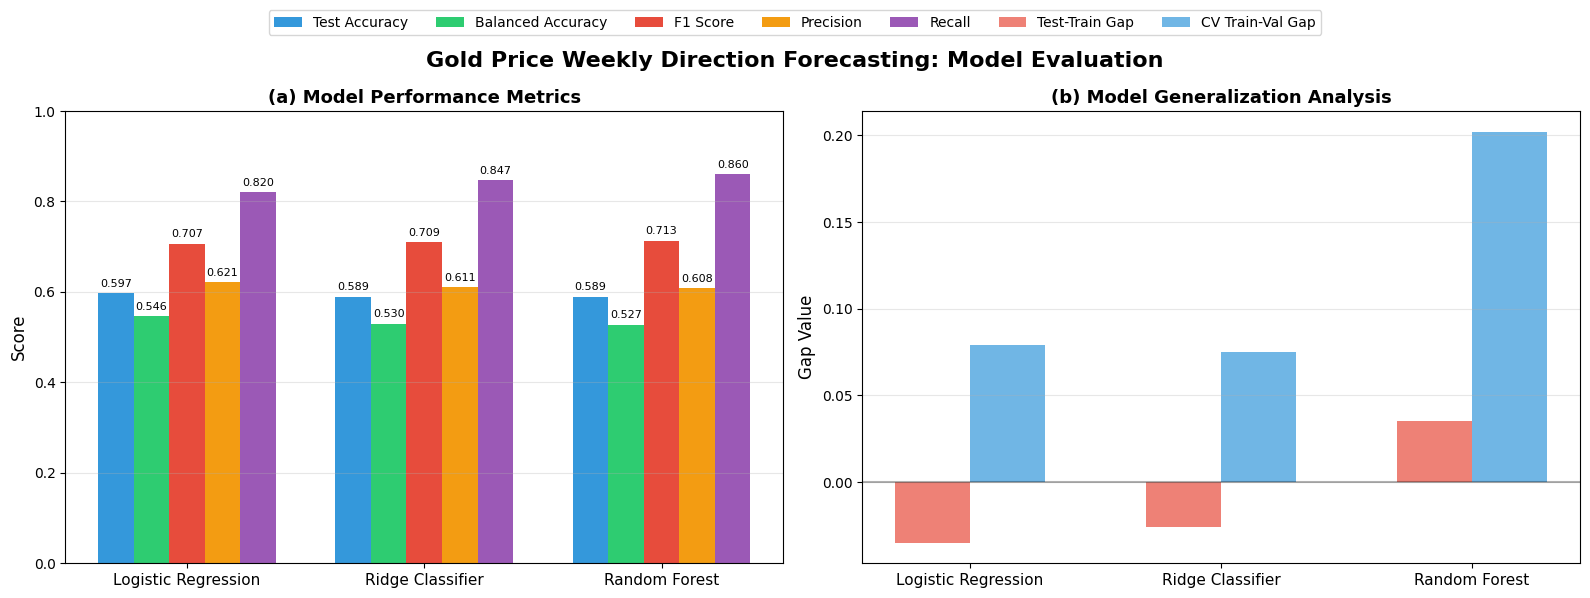

In [260]:
# After your analysis:
best_model_name, best_model_data, comparison_df = analyze_and_compare_models(results_dict)

# Call the function:
fig = create_executive_summary_chart(comparison_df)
plt.show()
fig.savefig('model_evaluation.png', dpi=300, bbox_inches='tight', facecolor='white')

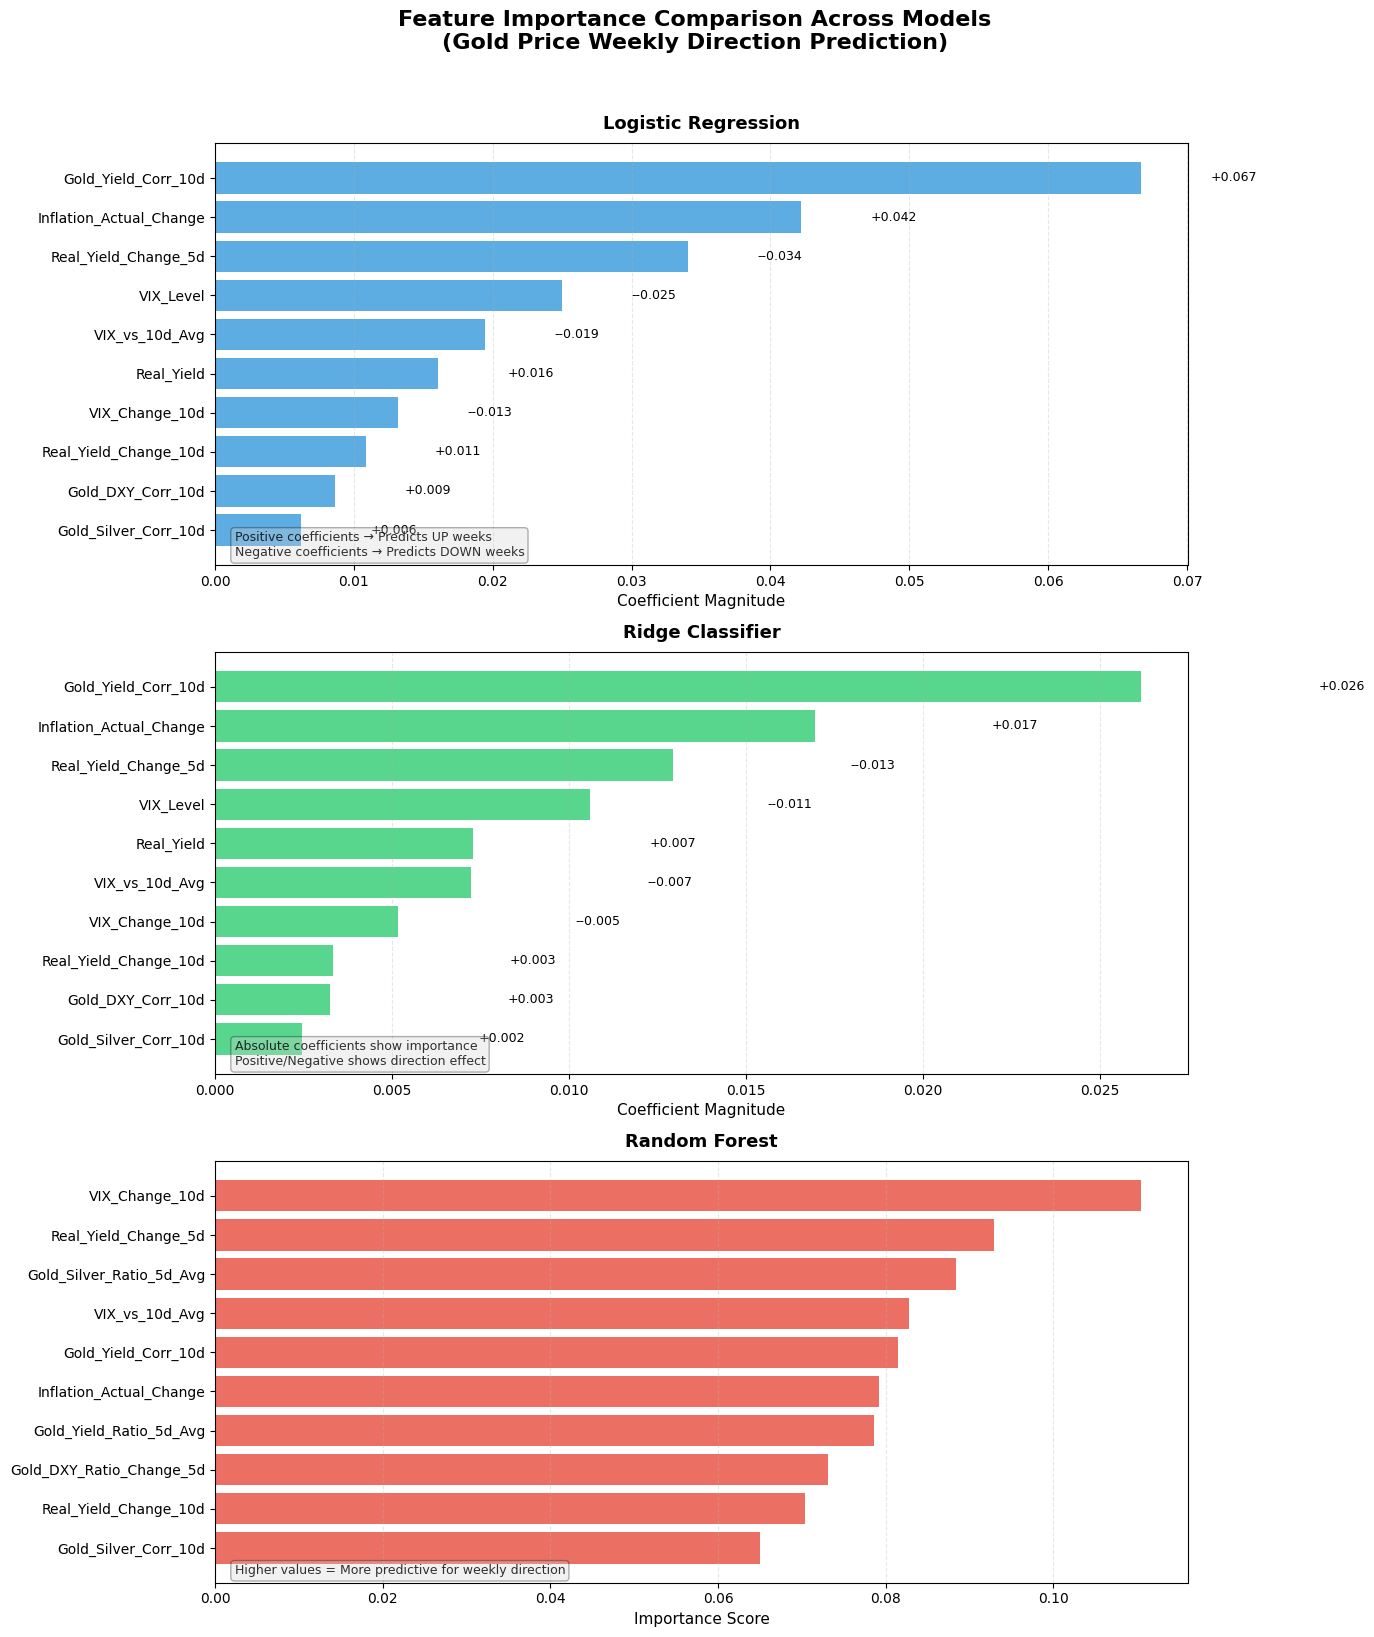

In [243]:
def plot_feature_importance_comparison(results_dict, feature_names):
    """
    Compare feature importance across all three models
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 16))
    fig.suptitle('Feature Importance Comparison Across Models\n(Gold Price Weekly Direction Prediction)',
                 fontsize=16, fontweight='bold', y=1.02)

    models_to_plot = ['Logistic Regression', 'Ridge Classifier', 'Random Forest']
    colors = ['#3498db', '#2ecc71', '#e74c3c']

    for idx, (model_name, color) in enumerate(zip(models_to_plot, colors)):
        ax = axes[idx]

        if model_name in results_dict:
            model_data = results_dict[model_name]['results']

            if 'feature_importance' in model_data and model_data['feature_importance'] is not None:
                feat_imp = model_data['feature_importance']

                # Extract top 10 features
                if 'Abs_Coefficient' in feat_imp.columns:  # For linear models
                    top_features = feat_imp.head(10).copy()
                    bars = ax.barh(range(len(top_features)),
                                  top_features['Abs_Coefficient'].values,
                                  color=color, alpha=0.8)

                    # Add coefficient values with signs
                    for i, (_, row) in enumerate(top_features.iterrows()):
                        sign = "+" if row['Coefficient'] > 0 else "-"
                        ax.text(row['Abs_Coefficient'] + 0.005, i,
                               f"{sign}{row['Coefficient']:.3f}",
                               va='center', fontsize=9)
                else:  # For Random Forest
                    top_features = feat_imp.head(10).copy()
                    bars = ax.barh(range(len(top_features)),
                                  top_features['Importance'].values,
                                  color=color, alpha=0.8)

                ax.set_yticks(range(len(top_features)))
                ax.set_yticklabels(top_features['Feature'].tolist(), fontsize=10)
                ax.invert_yaxis()
                ax.set_xlabel('Importance Score' if 'Importance' in feat_imp.columns else 'Coefficient Magnitude',
                             fontsize=11)
                ax.set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)

                # Add grid for readability
                ax.grid(True, axis='x', alpha=0.3, linestyle='--')

        # Add interpretation
        interpretation = ""
        if model_name == 'Logistic Regression':
            interpretation = "Positive coefficients → Predicts UP weeks\nNegative coefficients → Predicts DOWN weeks"
        elif model_name == 'Ridge Classifier':
            interpretation = "Absolute coefficients show importance\nPositive/Negative shows direction effect"
        else:
            interpretation = "Higher values = More predictive for weekly direction"

        ax.text(0.02, 0.02, interpretation, transform=ax.transAxes,
                fontsize=9, alpha=0.8, bbox=dict(boxstyle="round,pad=0.3",
                facecolor='lightgray', alpha=0.3))

    plt.tight_layout()
    return fig

# Call the function after your model training
fig = plot_feature_importance_comparison(results_dict, selected_features)
plt.show()

In [264]:
def create_radar_chart_comparison(comparison_df):
    """
    Create an interesting radar chart comparing model performance
    """
    # Select metrics for radar chart
    metrics = ['Test Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']

    # Get model names and data
    model_names = comparison_df['Model'].values
    model_data = []

    for model in model_names:
        model_metrics = comparison_df[comparison_df['Model'] == model]
        values = [model_metrics[metric].values[0] for metric in metrics]
        model_data.append(values)

    # Number of metrics
    num_metrics = len(metrics)

    # Create angles for each metric
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon

    # Create figure with polar projection
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, polar=True)

    # Set background color
    fig.patch.set_facecolor('#f8f9fa')
    ax.set_facecolor('#ffffff')

    # Style each model with different colors and line styles
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Modern color palette
    line_styles = ['-', '--', '-.']
    fill_alphas = [0.15, 0.12, 0.10]

    # Plot each model
    for i, (model_name, data, color, line_style) in enumerate(zip(model_names, model_data, colors, line_styles)):
        # Close the data for the polygon
        data = data + data[:1]

        # Plot the line
        ax.plot(angles, data, color=color, linewidth=2.5, linestyle=line_style,
                label=model_name, marker='o', markersize=8, markeredgecolor='white',
                markeredgewidth=1.5)

        # Fill the area
        ax.fill(angles, data, color=color, alpha=fill_alphas[i])

    # Customize the chart
    ax.set_theta_offset(np.pi / 2)  # Start from top
    ax.set_theta_direction(-1)  # Clockwise direction

    # Set radial grid
    ax.set_rlabel_position(0)
    ax.set_ylim(0.4, 1.0)  # Set radial limits
    ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(['40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                       fontsize=10, color='#666666')
    ax.grid(True, color='#e0e0e0', alpha=0.7, linewidth=0.8)

    # Set metric labels with better formatting
    metric_labels = ['Accuracy\n(Test)', 'Balanced\nAccuracy', 'F1\nScore',
                     'Precision', 'Recall']
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12, fontweight='medium',
                      color='#333333')

    # Add inner grid lines for better readability
    for y in [0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.plot(angles, [y] * len(angles), color='#e0e0e0', linewidth=0.5, alpha=0.5)

    # Add benchmark line for random chance (50%)
    ax.plot(angles, [0.5] * len(angles), color='#999999', linewidth=1.5,
            linestyle=':', alpha=0.7, label='Random Chance (50%)')

    # Add a circle at 60% for reference
    ax.plot(angles, [0.6] * len(angles), color='#cccccc', linewidth=0.5,
            linestyle='--', alpha=0.3)

    # Create custom legend with better styling
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0),
                      fontsize=11, frameon=True, fancybox=True,
                      shadow=True, borderpad=1, labelspacing=1)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    legend.get_frame().set_edgecolor('#cccccc')

    # Add performance summary box
    best_model = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Test Accuracy']
    best_balanced = comparison_df.iloc[0]['Balanced Accuracy']

    summary_text = f"Performance Summary:\n"
    summary_text += f"• Best Model: {best_model}\n"
    summary_text += f"• Test Accuracy: {best_accuracy:.2%}\n"
    summary_text += f"• Balanced Acc: {best_balanced:.2%}\n"
    summary_text += f"• All models >80% Recall"

    # Add text box
    props = dict(boxstyle='round', facecolor='white', alpha=0.95,
                edgecolor='#cccccc', linewidth=1.5)
    ax.text(0.02, 0.02, summary_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props, color='#333333')

    # Add title with styling
    plt.suptitle('Model Performance Comparison: Gold Price Direction Forecasting',
                 fontsize=16, fontweight='bold', y=1.05, color='#2c3e50')
    plt.title('Radar Chart Analysis of Key Performance Metrics',
              fontsize=13, color='#7f8c8d', pad=20)

    # Add subtle watermark
    ax.text(0.5, 0.5, 'GOLD PRICE\nFORECASTING', transform=ax.transAxes,
           fontsize=40, color='#f0f0f0', alpha=0.1, ha='center', va='center',
           rotation=30, fontweight='bold')

    plt.tight_layout()
    return fig

# Or a more minimalist modern version:
def create_minimal_radar_chart(comparison_df):
    """
    Create a minimalist radar chart with modern aesthetics
    """
    metrics = ['Test Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall']
    model_names = comparison_df['Model'].values

    # Prepare data
    model_data = []
    for model in model_names:
        model_metrics = comparison_df[comparison_df['Model'] == model]
        values = [model_metrics[metric].values[0] for metric in metrics]
        model_data.append(values)

    # Angles for polar plot
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    # Create figure with dark theme
    fig = plt.figure(figsize=(14, 10), facecolor='#1a1a1a')
    ax = fig.add_subplot(111, polar=True, facecolor='#2d2d2d')

    # Modern gradient colors
    colors = [
        'linear-gradient(90deg, #FF6B6B, #FF8E53)',  # Orange-red gradient
        'linear-gradient(90deg, #4ECDC4, #44A08D)',  # Teal gradient
        'linear-gradient(90deg, #45B7D1, #96C93D)'   # Blue-green gradient
    ]

    # Solid colors for actual plotting (can't use gradients directly)
    solid_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    glows = ['#FF6B6B55', '#4ECDC455', '#45B7D155']

    # Plot each model with glow effect
    for i, (model_name, data, color, glow) in enumerate(zip(model_names, model_data, solid_colors, glows)):
        data_closed = data + data[:1]

        # Create glow effect (plot multiple times with decreasing opacity)
        for width, alpha in [(6, 0.3), (4, 0.2), (2, 0.1)]:
            ax.plot(angles, data_closed, color=glow, linewidth=width, alpha=alpha)

        # Main line
        line, = ax.plot(angles, data_closed, color=color, linewidth=3,
                       label=model_name, alpha=0.9)

        # Add data points with glow
        ax.scatter(angles, data_closed, s=100, color=color, edgecolors='white',
                  linewidth=2, zorder=10, alpha=0.9)

        # Add metric values at each point
        for angle, value in zip(angles[:-1], data):
            ax.text(angle, value + 0.03, f'{value:.3f}', ha='center', va='center',
                   fontsize=9, color='white', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor=color, alpha=0.8))

    # Customize polar grid
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_ylim(0.4, 1.0)

    # Stylish grid
    ax.grid(True, color='#444444', alpha=0.6, linewidth=0.8)
    ax.spines['polar'].set_color('#666666')

    # Metric labels with icon-like styling
    metric_labels = ['📊 Accuracy', '⚖️ Balanced', '🎯 F1 Score',
                     '📍 Precision', '🎯 Recall']
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=13, fontweight='bold',
                      color='#cccccc')

    # Radial labels
    ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(['', '50%', '60%', '70%', '80%', '90%', '100%'],
                       fontsize=11, color='#999999')

    # Add performance zones
    zone_colors = ['#FF6B6B20', '#FFE66D20', '#4ECDC420']
    zone_labels = ['Poor', 'Fair', 'Good', 'Excellent']
    zone_ranges = [0.4, 0.6, 0.8, 1.0]

    for i in range(len(zone_ranges)-1):
        ax.fill_between(angles, zone_ranges[i], zone_ranges[i+1],
                       color=zone_colors[i % len(zone_colors)], alpha=0.1)

    # Legend with modern styling
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0),
                      fontsize=12, frameon=True, fancybox=True,
                      shadow=True, borderpad=1)
    legend.get_frame().set_facecolor('#333333')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('#666666')
    for text in legend.get_texts():
        text.set_color('white')

    # Title with gradient-like effect
    plt.suptitle('GOLD PRICE DIRECTION FORECASTING',
                 fontsize=24, fontweight='bold', y=1.02,
                 color='white')
    plt.title('Comparative Analysis of Machine Learning Models',
              fontsize=16, color='#FF6B6B', pad=30)

    # Add subtle radial lines for depth
    for angle in angles[:-1]:
        ax.plot([angle, angle], [0.4, 1.0], color='#444444',
               linewidth=0.5, alpha=0.3, linestyle='--')

    plt.tight_layout()
    return fig

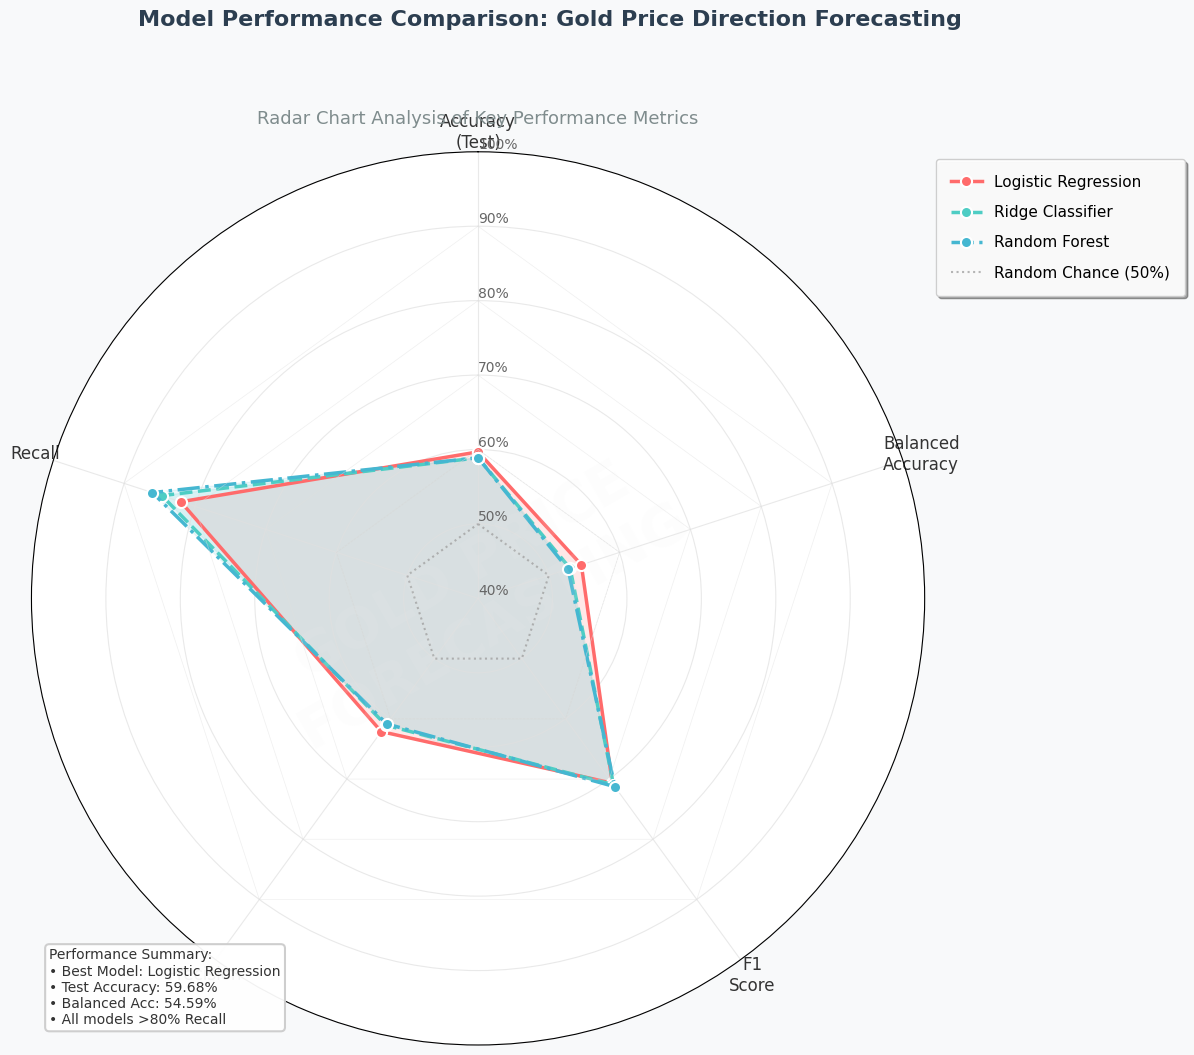

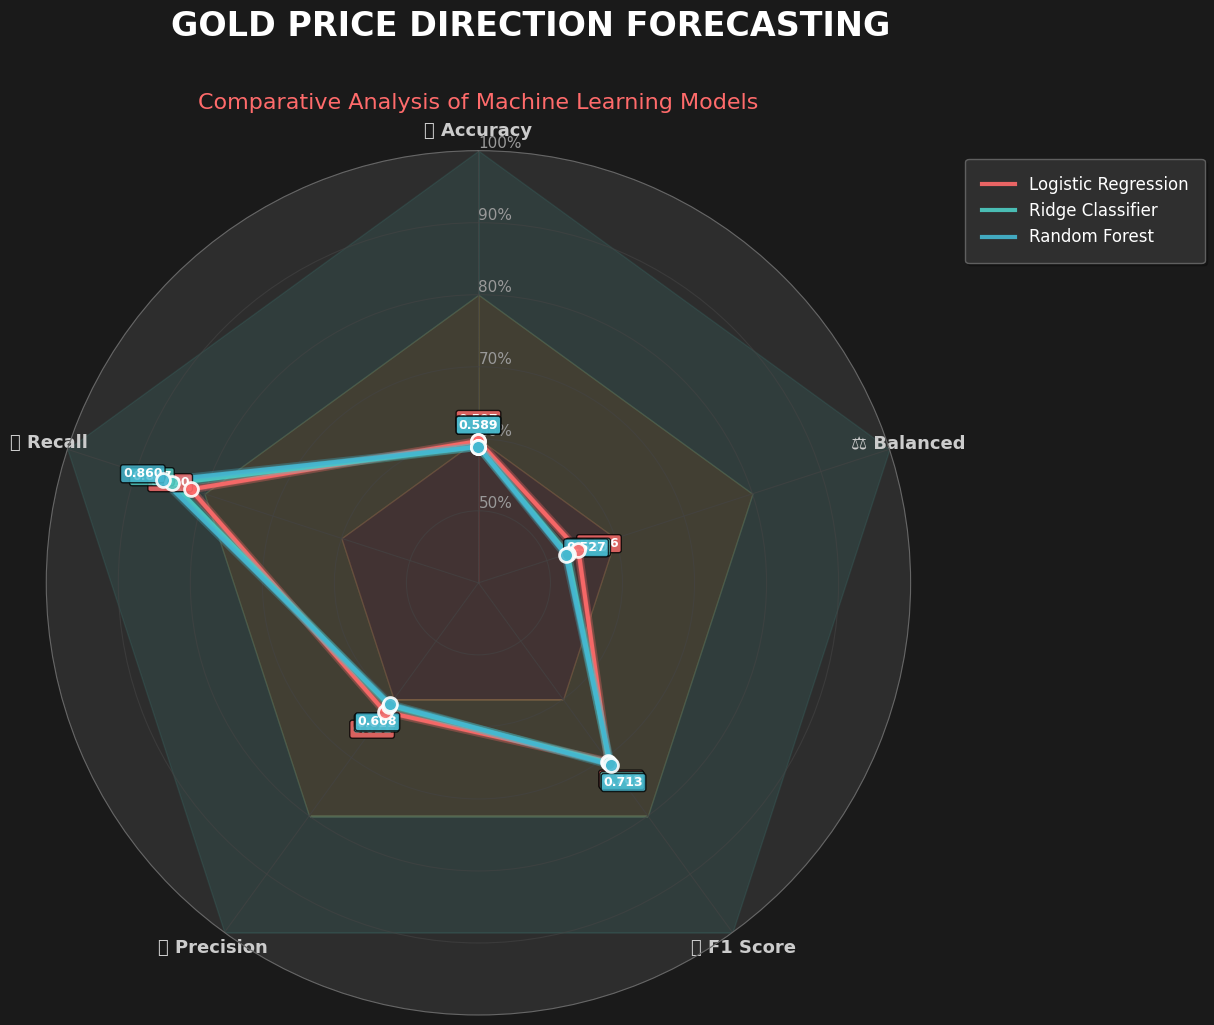

In [265]:
# Simple version (for dissertation)
fig1 = create_radar_chart_comparison(comparison_df)
plt.show()
fig1.savefig('radar_chart_simple.png', dpi=300, bbox_inches='tight', facecolor='white')

# Fancy version (for presentations)
fig2 = create_minimal_radar_chart(comparison_df)
plt.show()
fig2.savefig('radar_chart_fancy.png', dpi=300, bbox_inches='tight', facecolor='black')